# **NN**

### **Objetivo:** Implementar **Grid Search** a una arquitectura NN.

**Descripción:** Se realiza una búsqueda por Grilla considerando n° de neuronas por capa oculta y cantidad de capas ocultas.

**Grilla:**
N° de neuronas por capa oculta = [3, 6, 9, 12]
N° de capas ocultas = [1, 2, 4, 6, 8]


<img src="imagenes/reticula.jpg" alt="Retícula generada" width="400"/>

**Variables:**
1. componente zonal del viento (u)
2. Componente meridional del viento (v)
3. temperatura (temp)
4. altura geopotencial (alt_geop)

**Entrada:** Datos de reanálisis. Corresponde al tiempo *t.*
- longitud, latitud, u, v, temperatura y altura geopotencial

**Salida:** Inferencias, correspondientes al tiempo *t + 6hs.*
- u, v, temperatura y altura geopotencial

**Función de pérdida (MSE):**
1. Pérdida de datos etiquetados de las variables de salida, comparando el reanálisis y la inferenicia correspondientes a *t + 6 hs.*
2. Pérdida de datos etiquetados de las variables de salida, comparando el reanálisis y la inferenicia correspondientes a *t + 12 hs.*

**Normalizaciones:**
- Variables físicas por media/desvío estándar (M=0, SD=1).
- Variables espaciales por mínimo/máximo [0, 1].

**Hiperparámetros del modelo:**
- Cuatro capas en total, dos ocultas con 6 neuronas cada una.
- Función de activación: tangente hiperbólica. Dominio (-inf, inf). Rango (-1, 1).
- Learning rate:
  - *Cosine learning-rate schedule* de 0,001 a 0,0001
- Épocas: 30

In [1]:
# Instala librerías necesarias
!apt-get install -y libeccodes-data libeccodes-dev
!pip install torch torchvision torchaudio scipy
!pip install matplotlib pandas openpyxl seaborn

"apt-get" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.



[notice] A new release of pip is available: 24.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Importa las librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
import gc
import openpyxl
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
# Definir y verificar el dispositvo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("¿PyTorch detecta CUDA?:", torch.cuda.is_available())
print("Versión de CUDA en PyTorch:", torch.version.cuda)
print("GPU detectada:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Ninguna")

¿PyTorch detecta CUDA?: True
Versión de CUDA en PyTorch: 12.1
GPU detectada: NVIDIA GeForce RTX 3060


In [4]:
# Define las rutas a los archivos
"""
1: Geopotential: m**2 s**-2 (instant): isobaricInhPa: level 500: fcst time 0 hrs
2: Temperature: K (instant): isobaricInhPa :level 500: fcst time 0 hrs
3: U component of wind: m s**-1 (instant): isobaricInhPa: level 500: fcst time 0 hrs
4: V component of wind: m s**-1 (instant): isobaricInhPa: level 500: fcst time 0 hrs

Continua con 06Z, 12Z y 18Z respestando el orden.
"""
ruta_notebook = os.getcwd()
ruta_dir_padre = os.path.dirname(ruta_notebook)
ruta_files = ruta_dir_padre + '/files/'

filename_train = ruta_files + '200401201501.nc'
filename_val = ruta_files + '201601.nc'

In [5]:
# Cargar datos desde GRIB
def load_nc_data(filename):
    # Abre el archivo
    ds = Dataset(filename, mode='r')
    #print(ds.variables)
    
    # Selecciona las variables de interés
    alt_geop = ds.variables['z'][:].squeeze()        # Altura del geopotencial [m^2*s^-2]
    u = ds.variables['u'][:].squeeze()               # Componente zonal del viento [m/s]
    v = ds.variables['v'][:].squeeze()               # Componente meridional del viento [m/s]
    temp = ds.variables['t'][:].squeeze()            # Temperatura [K]
    lat = ds.variables['latitude'][:]                # Latitud [º Norte]
    lon = ds.variables['longitude'][:]               # Longitud [º Este]

    # Crear la retícula de puntos equiespaciaods
    lons, lats = np.meshgrid(lon, lat)

    # Extraer los valores para todos los tiempos: (Tiempo, Latitud, Longitud) - Convertir a Array
    alt_geop = np.array(alt_geop)
    temp = np.array(temp)
    u = np.array(u)
    v = np.array(v)
    lons = np.array(lons)
    lats = np.array(lats)

    return lons, lats, u, v, temp, alt_geop

In [6]:
# Función para normalización Min-Max
def min_max_normalize(data):
    data_min = np.min(data)
    data_max = np.max(data)

    if data_max == data_min:
        return np.zeros_like(data)  # Evita divisiones por cero en caso de valores constantes

    return (data - data_min) / (data_max - data_min)

In [7]:
# Función para normalización z-score de datos de entrenamiento
def z_score_train_normalize(data):
    mean = np.mean(data)
    std = np.std(data)

    if std == 0:
        return np.zeros_like(data)  # Evita divisiones por cero si los datos son constantes

    return mean, std, (data - mean) / std

In [8]:
# Función para normalización z-score
def z_score_normalize(data, mean, std):

    return (data - mean) / std

In [9]:
class NN(nn.Module):
    def __init__(self, hidden_size=6, num_hidden_layers=2):
        super(NN, self).__init__()
        layers = []

        input_size = 6   # x, y, u, v, temp, alt_geop
        output_size = 4  # u, v, temp, alt_geop (en t + Δt)

        # Capa de entrada
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.Tanh())

        # Capas ocultas intermedias
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())

        # Capa de salida
        layers.append(nn.Linear(hidden_size, output_size))

        self.net = nn.Sequential(*layers)

    def forward(self, x, y, u, v, temp, alt_geop):
        inputs = torch.cat([x, y, u, v, temp, alt_geop], dim=1)
        output = self.net(inputs)
        u_pred, v_pred, temp_pred, alt_geop_pred = output[:, 0:1], output[:, 1:2], output[:, 2:3], output[:, 3:4]
        return u_pred, v_pred, temp_pred, alt_geop_pred

In [10]:
# Función de pérdida de datos etiquetados (error cuadrático)
def label_loss(u_pred, v_pred, temp_pred, alt_geop_pred, u_data, v_data, temp_data, alt_geop_data):

    return torch.mean((u_pred - u_data)**2 + (v_pred - v_data)**2 + (temp_pred - temp_data)**2 + (alt_geop_pred - alt_geop_data)**2)

In [11]:
# Función para calcular MSE utilizando datos e inferencias
def mse_calculated(u_pred, v_pred, temp_pred, alt_geop_pred, u_data, v_data, temp_data, alt_geop_data):

    return torch.mean((u_pred - u_data)**2 + (v_pred - v_data)**2 + (temp_pred - temp_data)**2 + (alt_geop_pred - alt_geop_data)**2)

In [12]:
# Cargar datos de entrenamiento
"""
Dimensiones:

Variables físicas [tiempo, latitud, longitud]: (4*365, 161, 121)
Variables espaciales [latitud, longitud]: (161, 121)
"""
lons, lats, u_train, v_train, temp_train, alt_geop_train = load_nc_data(filename_train)

In [13]:
# Definir la cantidad total de reanálisis horarios
dims_train = u_train.shape
train_num_reanalysis_hours = dims_train[0]
print(f"Cantidad de reanálisis para entrenamiento disponibles: {train_num_reanalysis_hours}")

Cantidad de reanálisis para entrenamiento disponibles: 1488


In [14]:
# Cargar datos de validación
"""
Dimensiones:

Variables físicas [u, v, temperatura, altura geopotencial]: (4*31, 161, 121)
Variables espaciales [latitud, longitud]: (161, 121)
"""
*_, u_val, v_val, temp_val, alt_geop_val = load_nc_data(filename_val)

In [15]:
# Definir la cantidad total de reanálisis horarios
dims_val = u_val.shape
val_num_reanalysis_hours = dims_val[0]
print(f"Cantidad de reanálisis para validación disponibles: {val_num_reanalysis_hours}")

Cantidad de reanálisis para validación disponibles: 124


In [16]:
# Normalizar variables espaciales de entrada
lons = min_max_normalize(lons)
lats = min_max_normalize(lats)

In [17]:
# Tensorizar datos de entrada espacial
"""
Dimensiones de los Tensores: torch.Size([19481, 1]), debido a 161 x 121 = 19481
"""
lons_tensor = torch.tensor(lons.reshape(-1, 1), dtype=torch.float32)
lats_tensor = torch.tensor(lats.reshape(-1, 1), dtype=torch.float32)

In [18]:
# Separar los tiempos para armar los tensores de entrenamiento
def separate_time(ini, mid, fin, u, v, temp, alt_geop):
  """
  Separa los datos de las variables físicas en el inicio, el tiempo intermedio
  que es 06 horas y el tiempo final de 12 horas desde el inicio.
  En todos los casos son en retículas de latitud/longitud.
  """
  u_ini, u_mid, u_fin = u[ini, :, :], u[mid, :, :], u[fin, :, :]
  v_ini, v_mid, v_fin = v[ini, :, :], v[mid, :, :], v[fin, :, :]
  temp_ini, temp_mid, temp_fin = temp[ini, :, :], temp[mid, :, :], temp[fin, :, :]
  alt_geop_ini, alt_geop_mid, alt_geop_fin = alt_geop[ini, :, :], alt_geop[mid, :, :], alt_geop[fin, :, :]

  return u_ini, v_ini, temp_ini, alt_geop_ini, u_mid, v_mid, temp_mid, alt_geop_mid, u_fin, v_fin, temp_fin, alt_geop_fin

In [19]:
# Normalizar datos de entrenamiento
u_train_mean, u_train_std, u_norm_train = z_score_train_normalize(u_train)
v_train_mean, v_train_std, v_norm_train = z_score_train_normalize(v_train)
temp_train_mean, temp_train_std, temp_norm_train = z_score_train_normalize(temp_train)
alt_geop_train_mean, alt_geop_train_std, alt_geop_norm_train = z_score_train_normalize(alt_geop_train)

In [20]:
# Normalizar datos de validación
u_norm_val = z_score_normalize(u_val, u_train_mean, u_train_std)
v_norm_val = z_score_normalize(v_val, v_train_mean, v_train_std)
temp_norm_val = z_score_normalize(temp_val, temp_train_mean, temp_train_std)
alt_geop_norm_val = z_score_normalize(alt_geop_val, alt_geop_train_mean, alt_geop_train_std)

In [21]:
# Tensorizar los datos
def tensorize_data(u_ini, v_ini, temp_ini, alt_geop_ini, u_mid, v_mid, temp_mid, alt_geop_mid, u_fin, v_fin, temp_fin, alt_geop_fin):
  """
  Tensorizar los datos de las variables físicas en el inicio, el tiempo intermedio
  que es 06 horas y el tiempo final de 12 horas desde el inicio.
  """
  u_tensor_ini = torch.tensor(u_ini.reshape(-1, 1), dtype=torch.float32)
  v_tensor_ini = torch.tensor(v_ini.reshape(-1, 1), dtype=torch.float32)
  temp_tensor_ini = torch.tensor(temp_ini.reshape(-1, 1), dtype=torch.float32)
  alt_geop_tensor_ini = torch.tensor(alt_geop_ini.reshape(-1, 1), dtype=torch.float32)
  u_tensor_mid = torch.tensor(u_mid.reshape(-1, 1), dtype=torch.float32)
  v_tensor_mid = torch.tensor(v_mid.reshape(-1, 1), dtype=torch.float32)
  temp_tensor_mid = torch.tensor(temp_mid.reshape(-1, 1), dtype=torch.float32)
  alt_geop_tensor_mid = torch.tensor(alt_geop_mid.reshape(-1, 1), dtype=torch.float32)
  u_tensor_fin = torch.tensor(u_fin.reshape(-1, 1), dtype=torch.float32)
  v_tensor_fin = torch.tensor(v_fin.reshape(-1, 1), dtype=torch.float32)
  temp_tensor_fin = torch.tensor(temp_fin.reshape(-1, 1), dtype=torch.float32)
  alt_geop_tensor_fin = torch.tensor(alt_geop_fin.reshape(-1, 1), dtype=torch.float32)

  return u_tensor_ini, v_tensor_ini, temp_tensor_ini, alt_geop_tensor_ini, u_tensor_mid, v_tensor_mid, temp_tensor_mid, alt_geop_tensor_mid, u_tensor_fin, v_tensor_fin, temp_tensor_fin, alt_geop_tensor_fin

### Punto de grilla [1, 1]

In [22]:
# Parámetros de la Red
hidden_size = 3
num_hidden_layers = 1

In [23]:
# Inicializar modelo
model = NN(hidden_size=hidden_size, num_hidden_layers=num_hidden_layers)
"""
hidden_size: cantidad de neuronas de cada capa oculta.
num_hidden_layers: cantidad de capas ocultas.
"""

'\nhidden_size: cantidad de neuronas de cada capa oculta.\nnum_hidden_layers: cantidad de capas ocultas.\n'

In [24]:
print(model)

NN(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=3, bias=True)
    (1): Tanh()
    (2): Linear(in_features=3, out_features=4, bias=True)
  )
)


In [25]:
# Mover el modelo a la GPU
model = model.to(device)

In [26]:
# Mover los tensores espaciales a la GPU
lons_tensor = lons_tensor.to(device)
lats_tensor = lats_tensor.to(device)

In [27]:
# Mover los tensores físicos a la GPU
def move_tensors(u_tensor_move, v_tensor_move, temp_tensor_move, alt_geop_tensor_move, dispositivo=device):
    u_tensor_move = u_tensor_move.to(dispositivo)
    v_tensor_move = v_tensor_move.to(dispositivo)
    temp_tensor_move = temp_tensor_move.to(dispositivo)
    alt_geop_tensor_move = alt_geop_tensor_move.to(dispositivo)

    return u_tensor_move, v_tensor_move, temp_tensor_move, alt_geop_tensor_move

In [28]:
# Inicializar el almacenaje de mse para graficar
train_mses_avg = []
val_mses_avg = []

In [29]:
# Inicializar hiperparámetros
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 30

# Definir el scheduler para un Cosine Learning-Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

# Generar tamaños de conjuntos de entrenamiento
partials_train_num_reanalysis_hours =[1488]

# Número de rentrenamientos en val
num_retrains_val = val_num_reanalysis_hours - 2

In [30]:
print(partials_train_num_reanalysis_hours)

[1488]


In [31]:
# Cálculo de curvas de entrenamiento
for partial_train_num_reanalysis_hours in partials_train_num_reanalysis_hours:

  # Número de rentrenamientos en train
  num_retrains_train = partial_train_num_reanalysis_hours - 2
  
  print(f"Iniciando entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Recorrer épocas
  for epoch in range(epochs):

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2

    # ENTRENAMIENTO
    # Recorriendo los reanálisis
    for retrain in range(num_retrains_train):

      optimizer.zero_grad()

      # Separar tiempos de datos etiquetados
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, usados durante el entrenameinto, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Habilitar la diferenciación automática variables espaciales
      lons_tensor.requires_grad_(True)
      lats_tensor.requires_grad_(True)
      # Habilitar la diferenciación automática variable físicas
      u_tensor_ini_train.requires_grad_(True)
      v_tensor_ini_train.requires_grad_(True)
      temp_tensor_ini_train.requires_grad_(True)
      alt_geop_tensor_ini_train.requires_grad_(True)
      u_tensor_mid_train.requires_grad_(True)
      v_tensor_mid_train.requires_grad_(True)
      temp_tensor_mid_train.requires_grad_(True)
      alt_geop_tensor_mid_train.requires_grad_(True)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, usados durante el entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12), usados durante el entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de pérdidas datos etiquetados
      loss_ini_mid_datos_train = label_loss(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      loss_mid_fin_datos_train = label_loss(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_loss = loss_ini_mid_datos_train + loss_mid_fin_datos_train

      # Retropropagación
      train_loss.backward()
      optimizer.step()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1

    # Actualizar el learning rate con el scheduler
    scheduler.step()

  print(f"Finalizado entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Evaluar en conjunto de entrenamiento y validación
  with torch.no_grad():

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2
    ini_val = 0
    mid_val = 1
    fin_val = 2

    # ENTRENAMIENTO
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_train_mse = 0.0

    for retrain_train in range(num_retrains_train):

      # Separar tiempos de datos etiquetados de entrenamiento
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados de entrenamiento
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, de entrenamiento, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, de entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12) de entrada, de entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de mse datos etiquetados de entrenamiento
      mse_ini_mid_datos_train = mse_calculated(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      mse_mid_fin_datos_train = mse_calculated(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_mse = 0.5*mse_ini_mid_datos_train + 0.5*mse_mid_fin_datos_train

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_train_mse += train_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1
  
    # Calcular los mse medias
    avg_train_mse = total_train_mse / partial_train_num_reanalysis_hours
    # Guardar mse para gráficas
    train_mses_avg.append(avg_train_mse)

    print(f"Average Train MSE: {avg_train_mse:.2f}")

    # VALIDACIÓN
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_val_mse = 0.0

    for retrain_val in range(num_retrains_val):

      # Separar tiempos de datos etiquetados de validación
      u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val = separate_time(ini_val, mid_val, fin_val, u_norm_val, v_norm_val, temp_norm_val, alt_geop_norm_val)
      # Tensorizar datos etiquetados de validación
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = tensorize_data(u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val)

      # Mover los tensores (t=0) de entrada, de validación, a device
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val = move_tensors(u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)
      u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val = move_tensors(u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = move_tensors(u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)

      # Primera predicción del modelo sobre datos de validación
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = model(lons_tensor, lats_tensor, u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)

      # Mover los tensores (t=6) de entrada, de validación, a device
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = move_tensors(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Segunda predicción del modelo sobre datos de validación
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = model(lons_tensor, lats_tensor, u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Mover los tensores (t=12) de entrada, de validación, a device
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = move_tensors(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val)

      # Cálculo de mse datos etiquetados de validación
      mse_ini_mid_datos_val = mse_calculated(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      mse_mid_fin_datos_val = mse_calculated(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)
      val_mse = 0.5*mse_ini_mid_datos_val + 0.5*mse_mid_fin_datos_val

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_val_mse += val_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_val += 1
      mid_val += 1
      fin_val += 1
  
    # Calcular los mse medias
    avg_val_mse = total_val_mse / val_num_reanalysis_hours
    # Guardar mse para gráficas
    val_mses_avg.append(avg_val_mse)

    print(f"Average Val MSE: {avg_val_mse:.2f}")
    print("--"*30)

Iniciando entrenamiento con 1488 cantidad de reanálisis.
Finalizado entrenamiento con 1488 cantidad de reanálisis.
Average Train MSE: 0.78
Average Val MSE: 0.77
------------------------------------------------------------


In [32]:
# Liberar al dispositivo
del model, optimizer, scheduler
del train_loss, total_train_mse, train_mse
del avg_train_mse, train_mses_avg
del total_val_mse, val_mse, avg_val_mse, val_mses_avg
gc.collect()
torch.cuda.empty_cache()

### Punto de grilla [1, 2]

In [33]:
# Parámetros de la Red
hidden_size = 3
num_hidden_layers = 2

In [34]:
# Inicializar modelo
model = NN(hidden_size=hidden_size, num_hidden_layers=num_hidden_layers)
"""
hidden_size: cantidad de neuronas de cada capa oculta.
num_hidden_layers: cantidad de capas ocultas.
"""

'\nhidden_size: cantidad de neuronas de cada capa oculta.\nnum_hidden_layers: cantidad de capas ocultas.\n'

In [35]:
print(model)

NN(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=3, bias=True)
    (1): Tanh()
    (2): Linear(in_features=3, out_features=3, bias=True)
    (3): Tanh()
    (4): Linear(in_features=3, out_features=4, bias=True)
  )
)


In [36]:
# Mover el modelo a la GPU
model = model.to(device)

In [37]:
# Mover los tensores espaciales a la GPU
lons_tensor = lons_tensor.to(device)
lats_tensor = lats_tensor.to(device)

In [38]:
# Inicializar el almacenaje de mse para graficar
train_mses_avg = []
val_mses_avg = []

In [39]:
# Inicializar hiperparámetros
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir el scheduler para un Cosine Learning-Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

In [40]:
# Cálculo de curvas de entrenamiento
for partial_train_num_reanalysis_hours in partials_train_num_reanalysis_hours:

  # Número de rentrenamientos en train
  num_retrains_train = partial_train_num_reanalysis_hours - 2
  
  print(f"Iniciando entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Recorrer épocas
  for epoch in range(epochs):

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2

    # ENTRENAMIENTO
    # Recorriendo los reanálisis
    for retrain in range(num_retrains_train):

      optimizer.zero_grad()

      # Separar tiempos de datos etiquetados
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, usados durante el entrenameinto, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Habilitar la diferenciación automática variables espaciales
      lons_tensor.requires_grad_(True)
      lats_tensor.requires_grad_(True)
      # Habilitar la diferenciación automática variable físicas
      u_tensor_ini_train.requires_grad_(True)
      v_tensor_ini_train.requires_grad_(True)
      temp_tensor_ini_train.requires_grad_(True)
      alt_geop_tensor_ini_train.requires_grad_(True)
      u_tensor_mid_train.requires_grad_(True)
      v_tensor_mid_train.requires_grad_(True)
      temp_tensor_mid_train.requires_grad_(True)
      alt_geop_tensor_mid_train.requires_grad_(True)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, usados durante el entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12), usados durante el entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de pérdidas datos etiquetados
      loss_ini_mid_datos_train = label_loss(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      loss_mid_fin_datos_train = label_loss(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_loss = loss_ini_mid_datos_train + loss_mid_fin_datos_train

      # Retropropagación
      train_loss.backward()
      optimizer.step()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1

    # Actualizar el learning rate con el scheduler
    scheduler.step()

  print(f"Finalizado entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Evaluar en conjunto de entrenamiento y validación
  with torch.no_grad():

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2
    ini_val = 0
    mid_val = 1
    fin_val = 2

    # ENTRENAMIENTO
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_train_mse = 0.0

    for retrain_train in range(num_retrains_train):

      # Separar tiempos de datos etiquetados de entrenamiento
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados de entrenamiento
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, de entrenamiento, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, de entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12) de entrada, de entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de mse datos etiquetados de entrenamiento
      mse_ini_mid_datos_train = mse_calculated(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      mse_mid_fin_datos_train = mse_calculated(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_mse = 0.5*mse_ini_mid_datos_train + 0.5*mse_mid_fin_datos_train

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_train_mse += train_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1
  
    # Calcular los mse medias
    avg_train_mse = total_train_mse / partial_train_num_reanalysis_hours
    # Guardar mse para gráficas
    train_mses_avg.append(avg_train_mse)

    print(f"Average Train MSE: {avg_train_mse:.2f}")

    # VALIDACIÓN
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_val_mse = 0.0

    for retrain_val in range(num_retrains_val):

      # Separar tiempos de datos etiquetados de validación
      u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val = separate_time(ini_val, mid_val, fin_val, u_norm_val, v_norm_val, temp_norm_val, alt_geop_norm_val)
      # Tensorizar datos etiquetados de validación
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = tensorize_data(u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val)

      # Mover los tensores (t=0) de entrada, de validación, a device
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val = move_tensors(u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)
      u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val = move_tensors(u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = move_tensors(u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)

      # Primera predicción del modelo sobre datos de validación
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = model(lons_tensor, lats_tensor, u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)

      # Mover los tensores (t=6) de entrada, de validación, a device
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = move_tensors(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Segunda predicción del modelo sobre datos de validación
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = model(lons_tensor, lats_tensor, u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Mover los tensores (t=12) de entrada, de validación, a device
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = move_tensors(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val)

      # Cálculo de mse datos etiquetados de validación
      mse_ini_mid_datos_val = mse_calculated(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      mse_mid_fin_datos_val = mse_calculated(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)
      val_mse = 0.5*mse_ini_mid_datos_val + 0.5*mse_mid_fin_datos_val

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_val_mse += val_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_val += 1
      mid_val += 1
      fin_val += 1
  
    # Calcular los mse medias
    avg_val_mse = total_val_mse / val_num_reanalysis_hours
    # Guardar mse para gráficas
    val_mses_avg.append(avg_val_mse)

    print(f"Average Val MSE: {avg_val_mse:.2f}")
    print("--"*30)

Iniciando entrenamiento con 1488 cantidad de reanálisis.
Finalizado entrenamiento con 1488 cantidad de reanálisis.
Average Train MSE: 0.79
Average Val MSE: 0.78
------------------------------------------------------------


In [41]:
# Liberar al dispositivo
del model, optimizer, scheduler
del train_loss, total_train_mse, train_mse
del avg_train_mse, train_mses_avg
del total_val_mse, val_mse, avg_val_mse, val_mses_avg
gc.collect()
torch.cuda.empty_cache()

### Punto de grilla [1, 3]

In [42]:
# Parámetros de la Red
hidden_size = 3
num_hidden_layers = 4

In [43]:
# Inicializar modelo
model = NN(hidden_size=hidden_size, num_hidden_layers=num_hidden_layers)
"""
hidden_size: cantidad de neuronas de cada capa oculta.
num_hidden_layers: cantidad de capas ocultas.
"""

'\nhidden_size: cantidad de neuronas de cada capa oculta.\nnum_hidden_layers: cantidad de capas ocultas.\n'

In [44]:
print(model)

NN(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=3, bias=True)
    (1): Tanh()
    (2): Linear(in_features=3, out_features=3, bias=True)
    (3): Tanh()
    (4): Linear(in_features=3, out_features=3, bias=True)
    (5): Tanh()
    (6): Linear(in_features=3, out_features=3, bias=True)
    (7): Tanh()
    (8): Linear(in_features=3, out_features=4, bias=True)
  )
)


In [45]:
# Mover el modelo a la GPU
model = model.to(device)

In [46]:
# Mover los tensores espaciales a la GPU
lons_tensor = lons_tensor.to(device)
lats_tensor = lats_tensor.to(device)

In [47]:
# Inicializar el almacenaje de mse para graficar
train_mses_avg = []
val_mses_avg = []

In [48]:
# Inicializar hiperparámetros
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir el scheduler para un Cosine Learning-Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

In [49]:
# Cálculo de curvas de entrenamiento
for partial_train_num_reanalysis_hours in partials_train_num_reanalysis_hours:

  # Número de rentrenamientos en train
  num_retrains_train = partial_train_num_reanalysis_hours - 2
  
  print(f"Iniciando entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Recorrer épocas
  for epoch in range(epochs):

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2

    # ENTRENAMIENTO
    # Recorriendo los reanálisis
    for retrain in range(num_retrains_train):

      optimizer.zero_grad()

      # Separar tiempos de datos etiquetados
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, usados durante el entrenameinto, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Habilitar la diferenciación automática variables espaciales
      lons_tensor.requires_grad_(True)
      lats_tensor.requires_grad_(True)
      # Habilitar la diferenciación automática variable físicas
      u_tensor_ini_train.requires_grad_(True)
      v_tensor_ini_train.requires_grad_(True)
      temp_tensor_ini_train.requires_grad_(True)
      alt_geop_tensor_ini_train.requires_grad_(True)
      u_tensor_mid_train.requires_grad_(True)
      v_tensor_mid_train.requires_grad_(True)
      temp_tensor_mid_train.requires_grad_(True)
      alt_geop_tensor_mid_train.requires_grad_(True)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, usados durante el entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12), usados durante el entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de pérdidas datos etiquetados
      loss_ini_mid_datos_train = label_loss(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      loss_mid_fin_datos_train = label_loss(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_loss = loss_ini_mid_datos_train + loss_mid_fin_datos_train

      # Retropropagación
      train_loss.backward()
      optimizer.step()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1

    # Actualizar el learning rate con el scheduler
    scheduler.step()

  print(f"Finalizado entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Evaluar en conjunto de entrenamiento y validación
  with torch.no_grad():

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2
    ini_val = 0
    mid_val = 1
    fin_val = 2

    # ENTRENAMIENTO
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_train_mse = 0.0

    for retrain_train in range(num_retrains_train):

      # Separar tiempos de datos etiquetados de entrenamiento
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados de entrenamiento
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, de entrenamiento, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, de entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12) de entrada, de entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de mse datos etiquetados de entrenamiento
      mse_ini_mid_datos_train = mse_calculated(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      mse_mid_fin_datos_train = mse_calculated(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_mse = 0.5*mse_ini_mid_datos_train + 0.5*mse_mid_fin_datos_train

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_train_mse += train_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1
  
    # Calcular los mse medias
    avg_train_mse = total_train_mse / partial_train_num_reanalysis_hours
    # Guardar mse para gráficas
    train_mses_avg.append(avg_train_mse)

    print(f"Average Train MSE: {avg_train_mse:.2f}")

    # VALIDACIÓN
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_val_mse = 0.0

    for retrain_val in range(num_retrains_val):

      # Separar tiempos de datos etiquetados de validación
      u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val = separate_time(ini_val, mid_val, fin_val, u_norm_val, v_norm_val, temp_norm_val, alt_geop_norm_val)
      # Tensorizar datos etiquetados de validación
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = tensorize_data(u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val)

      # Mover los tensores (t=0) de entrada, de validación, a device
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val = move_tensors(u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)
      u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val = move_tensors(u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = move_tensors(u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)

      # Primera predicción del modelo sobre datos de validación
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = model(lons_tensor, lats_tensor, u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)

      # Mover los tensores (t=6) de entrada, de validación, a device
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = move_tensors(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Segunda predicción del modelo sobre datos de validación
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = model(lons_tensor, lats_tensor, u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Mover los tensores (t=12) de entrada, de validación, a device
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = move_tensors(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val)

      # Cálculo de mse datos etiquetados de validación
      mse_ini_mid_datos_val = mse_calculated(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      mse_mid_fin_datos_val = mse_calculated(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)
      val_mse = 0.5*mse_ini_mid_datos_val + 0.5*mse_mid_fin_datos_val

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_val_mse += val_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_val += 1
      mid_val += 1
      fin_val += 1
  
    # Calcular los mse medias
    avg_val_mse = total_val_mse / val_num_reanalysis_hours
    # Guardar mse para gráficas
    val_mses_avg.append(avg_val_mse)

    print(f"Average Val MSE: {avg_val_mse:.2f}")
    print("--"*30)

Iniciando entrenamiento con 1488 cantidad de reanálisis.
Finalizado entrenamiento con 1488 cantidad de reanálisis.
Average Train MSE: 0.79
Average Val MSE: 0.79
------------------------------------------------------------


In [50]:
# Liberar al dispositivo
del model, optimizer, scheduler
del train_loss, total_train_mse, train_mse
del avg_train_mse, train_mses_avg
del total_val_mse, val_mse, avg_val_mse, val_mses_avg
gc.collect()
torch.cuda.empty_cache()

### Punto de grilla [1, 4]

In [51]:
# Parámetros de la Red
hidden_size = 3
num_hidden_layers = 6

In [52]:
# Inicializar modelo
model = NN(hidden_size=hidden_size, num_hidden_layers=num_hidden_layers)
"""
hidden_size: cantidad de neuronas de cada capa oculta.
num_hidden_layers: cantidad de capas ocultas.
"""

'\nhidden_size: cantidad de neuronas de cada capa oculta.\nnum_hidden_layers: cantidad de capas ocultas.\n'

In [53]:
print(model)

NN(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=3, bias=True)
    (1): Tanh()
    (2): Linear(in_features=3, out_features=3, bias=True)
    (3): Tanh()
    (4): Linear(in_features=3, out_features=3, bias=True)
    (5): Tanh()
    (6): Linear(in_features=3, out_features=3, bias=True)
    (7): Tanh()
    (8): Linear(in_features=3, out_features=3, bias=True)
    (9): Tanh()
    (10): Linear(in_features=3, out_features=3, bias=True)
    (11): Tanh()
    (12): Linear(in_features=3, out_features=4, bias=True)
  )
)


In [54]:
# Mover el modelo a la GPU
model = model.to(device)

In [55]:
# Mover los tensores espaciales a la GPU
lons_tensor = lons_tensor.to(device)
lats_tensor = lats_tensor.to(device)

In [56]:
# Inicializar el almacenaje de mse para graficar
train_mses_avg = []
val_mses_avg = []

In [57]:
# Inicializar hiperparámetros
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir el scheduler para un Cosine Learning-Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

In [58]:
# Cálculo de curvas de entrenamiento
for partial_train_num_reanalysis_hours in partials_train_num_reanalysis_hours:

  # Número de rentrenamientos en train
  num_retrains_train = partial_train_num_reanalysis_hours - 2
  
  print(f"Iniciando entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Recorrer épocas
  for epoch in range(epochs):

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2

    # ENTRENAMIENTO
    # Recorriendo los reanálisis
    for retrain in range(num_retrains_train):

      optimizer.zero_grad()

      # Separar tiempos de datos etiquetados
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, usados durante el entrenameinto, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Habilitar la diferenciación automática variables espaciales
      lons_tensor.requires_grad_(True)
      lats_tensor.requires_grad_(True)
      # Habilitar la diferenciación automática variable físicas
      u_tensor_ini_train.requires_grad_(True)
      v_tensor_ini_train.requires_grad_(True)
      temp_tensor_ini_train.requires_grad_(True)
      alt_geop_tensor_ini_train.requires_grad_(True)
      u_tensor_mid_train.requires_grad_(True)
      v_tensor_mid_train.requires_grad_(True)
      temp_tensor_mid_train.requires_grad_(True)
      alt_geop_tensor_mid_train.requires_grad_(True)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, usados durante el entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12), usados durante el entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de pérdidas datos etiquetados
      loss_ini_mid_datos_train = label_loss(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      loss_mid_fin_datos_train = label_loss(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_loss = loss_ini_mid_datos_train + loss_mid_fin_datos_train

      # Retropropagación
      train_loss.backward()
      optimizer.step()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1

    # Actualizar el learning rate con el scheduler
    scheduler.step()

  print(f"Finalizado entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Evaluar en conjunto de entrenamiento y validación
  with torch.no_grad():

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2
    ini_val = 0
    mid_val = 1
    fin_val = 2

    # ENTRENAMIENTO
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_train_mse = 0.0

    for retrain_train in range(num_retrains_train):

      # Separar tiempos de datos etiquetados de entrenamiento
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados de entrenamiento
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, de entrenamiento, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, de entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12) de entrada, de entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de mse datos etiquetados de entrenamiento
      mse_ini_mid_datos_train = mse_calculated(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      mse_mid_fin_datos_train = mse_calculated(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_mse = 0.5*mse_ini_mid_datos_train + 0.5*mse_mid_fin_datos_train

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_train_mse += train_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1
  
    # Calcular los mse medias
    avg_train_mse = total_train_mse / partial_train_num_reanalysis_hours
    # Guardar mse para gráficas
    train_mses_avg.append(avg_train_mse)

    print(f"Average Train MSE: {avg_train_mse:.2f}")

    # VALIDACIÓN
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_val_mse = 0.0

    for retrain_val in range(num_retrains_val):

      # Separar tiempos de datos etiquetados de validación
      u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val = separate_time(ini_val, mid_val, fin_val, u_norm_val, v_norm_val, temp_norm_val, alt_geop_norm_val)
      # Tensorizar datos etiquetados de validación
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = tensorize_data(u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val)

      # Mover los tensores (t=0) de entrada, de validación, a device
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val = move_tensors(u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)
      u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val = move_tensors(u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = move_tensors(u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)

      # Primera predicción del modelo sobre datos de validación
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = model(lons_tensor, lats_tensor, u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)

      # Mover los tensores (t=6) de entrada, de validación, a device
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = move_tensors(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Segunda predicción del modelo sobre datos de validación
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = model(lons_tensor, lats_tensor, u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Mover los tensores (t=12) de entrada, de validación, a device
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = move_tensors(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val)

      # Cálculo de mse datos etiquetados de validación
      mse_ini_mid_datos_val = mse_calculated(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      mse_mid_fin_datos_val = mse_calculated(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)
      val_mse = 0.5*mse_ini_mid_datos_val + 0.5*mse_mid_fin_datos_val

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_val_mse += val_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_val += 1
      mid_val += 1
      fin_val += 1
  
    # Calcular los mse medias
    avg_val_mse = total_val_mse / val_num_reanalysis_hours
    # Guardar mse para gráficas
    val_mses_avg.append(avg_val_mse)

    print(f"Average Val MSE: {avg_val_mse:.2f}")
    print("--"*30)

Iniciando entrenamiento con 1488 cantidad de reanálisis.
Finalizado entrenamiento con 1488 cantidad de reanálisis.
Average Train MSE: 1.10
Average Val MSE: 1.04
------------------------------------------------------------


In [59]:
# Liberar al dispositivo
del model, optimizer, scheduler
del train_loss, total_train_mse, train_mse
del avg_train_mse, train_mses_avg
del total_val_mse, val_mse, avg_val_mse, val_mses_avg
gc.collect()
torch.cuda.empty_cache()

### Punto de grilla [1, 5]

In [60]:
# Parámetros de la Red
hidden_size = 3
num_hidden_layers = 8

In [61]:
# Inicializar modelo
model = NN(hidden_size=hidden_size, num_hidden_layers=num_hidden_layers)
"""
hidden_size: cantidad de neuronas de cada capa oculta.
num_hidden_layers: cantidad de capas ocultas.
"""

'\nhidden_size: cantidad de neuronas de cada capa oculta.\nnum_hidden_layers: cantidad de capas ocultas.\n'

In [62]:
print(model)

NN(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=3, bias=True)
    (1): Tanh()
    (2): Linear(in_features=3, out_features=3, bias=True)
    (3): Tanh()
    (4): Linear(in_features=3, out_features=3, bias=True)
    (5): Tanh()
    (6): Linear(in_features=3, out_features=3, bias=True)
    (7): Tanh()
    (8): Linear(in_features=3, out_features=3, bias=True)
    (9): Tanh()
    (10): Linear(in_features=3, out_features=3, bias=True)
    (11): Tanh()
    (12): Linear(in_features=3, out_features=3, bias=True)
    (13): Tanh()
    (14): Linear(in_features=3, out_features=3, bias=True)
    (15): Tanh()
    (16): Linear(in_features=3, out_features=4, bias=True)
  )
)


In [63]:
# Mover el modelo a la GPU
model = model.to(device)

In [64]:
# Mover los tensores espaciales a la GPU
lons_tensor = lons_tensor.to(device)
lats_tensor = lats_tensor.to(device)

In [65]:
# Inicializar el almacenaje de mse para graficar
train_mses_avg = []
val_mses_avg = []

In [66]:
# Inicializar hiperparámetros
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir el scheduler para un Cosine Learning-Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

In [67]:
# Cálculo de curvas de entrenamiento
for partial_train_num_reanalysis_hours in partials_train_num_reanalysis_hours:

  # Número de rentrenamientos en train
  num_retrains_train = partial_train_num_reanalysis_hours - 2
  
  print(f"Iniciando entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Recorrer épocas
  for epoch in range(epochs):

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2

    # ENTRENAMIENTO
    # Recorriendo los reanálisis
    for retrain in range(num_retrains_train):

      optimizer.zero_grad()

      # Separar tiempos de datos etiquetados
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, usados durante el entrenameinto, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Habilitar la diferenciación automática variables espaciales
      lons_tensor.requires_grad_(True)
      lats_tensor.requires_grad_(True)
      # Habilitar la diferenciación automática variable físicas
      u_tensor_ini_train.requires_grad_(True)
      v_tensor_ini_train.requires_grad_(True)
      temp_tensor_ini_train.requires_grad_(True)
      alt_geop_tensor_ini_train.requires_grad_(True)
      u_tensor_mid_train.requires_grad_(True)
      v_tensor_mid_train.requires_grad_(True)
      temp_tensor_mid_train.requires_grad_(True)
      alt_geop_tensor_mid_train.requires_grad_(True)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, usados durante el entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12), usados durante el entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de pérdidas datos etiquetados
      loss_ini_mid_datos_train = label_loss(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      loss_mid_fin_datos_train = label_loss(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_loss = loss_ini_mid_datos_train + loss_mid_fin_datos_train

      # Retropropagación
      train_loss.backward()
      optimizer.step()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1

    # Actualizar el learning rate con el scheduler
    scheduler.step()

  print(f"Finalizado entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Evaluar en conjunto de entrenamiento y validación
  with torch.no_grad():

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2
    ini_val = 0
    mid_val = 1
    fin_val = 2

    # ENTRENAMIENTO
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_train_mse = 0.0

    for retrain_train in range(num_retrains_train):

      # Separar tiempos de datos etiquetados de entrenamiento
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados de entrenamiento
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, de entrenamiento, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, de entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12) de entrada, de entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de mse datos etiquetados de entrenamiento
      mse_ini_mid_datos_train = mse_calculated(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      mse_mid_fin_datos_train = mse_calculated(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_mse = 0.5*mse_ini_mid_datos_train + 0.5*mse_mid_fin_datos_train

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_train_mse += train_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1
  
    # Calcular los mse medias
    avg_train_mse = total_train_mse / partial_train_num_reanalysis_hours
    # Guardar mse para gráficas
    train_mses_avg.append(avg_train_mse)

    print(f"Average Train MSE: {avg_train_mse:.2f}")

    # VALIDACIÓN
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_val_mse = 0.0

    for retrain_val in range(num_retrains_val):

      # Separar tiempos de datos etiquetados de validación
      u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val = separate_time(ini_val, mid_val, fin_val, u_norm_val, v_norm_val, temp_norm_val, alt_geop_norm_val)
      # Tensorizar datos etiquetados de validación
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = tensorize_data(u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val)

      # Mover los tensores (t=0) de entrada, de validación, a device
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val = move_tensors(u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)
      u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val = move_tensors(u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = move_tensors(u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)

      # Primera predicción del modelo sobre datos de validación
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = model(lons_tensor, lats_tensor, u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)

      # Mover los tensores (t=6) de entrada, de validación, a device
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = move_tensors(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Segunda predicción del modelo sobre datos de validación
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = model(lons_tensor, lats_tensor, u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Mover los tensores (t=12) de entrada, de validación, a device
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = move_tensors(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val)

      # Cálculo de mse datos etiquetados de validación
      mse_ini_mid_datos_val = mse_calculated(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      mse_mid_fin_datos_val = mse_calculated(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)
      val_mse = 0.5*mse_ini_mid_datos_val + 0.5*mse_mid_fin_datos_val

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_val_mse += val_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_val += 1
      mid_val += 1
      fin_val += 1
  
    # Calcular los mse medias
    avg_val_mse = total_val_mse / val_num_reanalysis_hours
    # Guardar mse para gráficas
    val_mses_avg.append(avg_val_mse)

    print(f"Average Val MSE: {avg_val_mse:.2f}")
    print("--"*30)

Iniciando entrenamiento con 1488 cantidad de reanálisis.
Finalizado entrenamiento con 1488 cantidad de reanálisis.
Average Train MSE: 1.54
Average Val MSE: 1.84
------------------------------------------------------------


In [68]:
# Liberar al dispositivo
del model, optimizer, scheduler
del train_loss, total_train_mse, train_mse
del avg_train_mse, train_mses_avg
del total_val_mse, val_mse, avg_val_mse, val_mses_avg
gc.collect()
torch.cuda.empty_cache()

### Punto de grilla [2, 1]

In [69]:
# Parámetros de la Red
hidden_size = 6
num_hidden_layers = 1

In [70]:
# Inicializar modelo
model = NN(hidden_size=hidden_size, num_hidden_layers=num_hidden_layers)
"""
hidden_size: cantidad de neuronas de cada capa oculta.
num_hidden_layers: cantidad de capas ocultas.
"""

'\nhidden_size: cantidad de neuronas de cada capa oculta.\nnum_hidden_layers: cantidad de capas ocultas.\n'

In [71]:
print(model)

NN(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=6, bias=True)
    (1): Tanh()
    (2): Linear(in_features=6, out_features=4, bias=True)
  )
)


In [72]:
# Mover el modelo a la GPU
model = model.to(device)

In [73]:
# Mover los tensores espaciales a la GPU
lons_tensor = lons_tensor.to(device)
lats_tensor = lats_tensor.to(device)

In [74]:
# Inicializar el almacenaje de mse para graficar
train_mses_avg = []
val_mses_avg = []

In [75]:
# Inicializar hiperparámetros
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir el scheduler para un Cosine Learning-Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

In [76]:
# Cálculo de curvas de entrenamiento
for partial_train_num_reanalysis_hours in partials_train_num_reanalysis_hours:

  # Número de rentrenamientos en train
  num_retrains_train = partial_train_num_reanalysis_hours - 2
  
  print(f"Iniciando entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Recorrer épocas
  for epoch in range(epochs):

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2

    # ENTRENAMIENTO
    # Recorriendo los reanálisis
    for retrain in range(num_retrains_train):

      optimizer.zero_grad()

      # Separar tiempos de datos etiquetados
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, usados durante el entrenameinto, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Habilitar la diferenciación automática variables espaciales
      lons_tensor.requires_grad_(True)
      lats_tensor.requires_grad_(True)
      # Habilitar la diferenciación automática variable físicas
      u_tensor_ini_train.requires_grad_(True)
      v_tensor_ini_train.requires_grad_(True)
      temp_tensor_ini_train.requires_grad_(True)
      alt_geop_tensor_ini_train.requires_grad_(True)
      u_tensor_mid_train.requires_grad_(True)
      v_tensor_mid_train.requires_grad_(True)
      temp_tensor_mid_train.requires_grad_(True)
      alt_geop_tensor_mid_train.requires_grad_(True)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, usados durante el entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12), usados durante el entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de pérdidas datos etiquetados
      loss_ini_mid_datos_train = label_loss(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      loss_mid_fin_datos_train = label_loss(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_loss = loss_ini_mid_datos_train + loss_mid_fin_datos_train

      # Retropropagación
      train_loss.backward()
      optimizer.step()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1

    # Actualizar el learning rate con el scheduler
    scheduler.step()

  print(f"Finalizado entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Evaluar en conjunto de entrenamiento y validación
  with torch.no_grad():

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2
    ini_val = 0
    mid_val = 1
    fin_val = 2

    # ENTRENAMIENTO
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_train_mse = 0.0

    for retrain_train in range(num_retrains_train):

      # Separar tiempos de datos etiquetados de entrenamiento
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados de entrenamiento
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, de entrenamiento, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, de entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12) de entrada, de entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de mse datos etiquetados de entrenamiento
      mse_ini_mid_datos_train = mse_calculated(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      mse_mid_fin_datos_train = mse_calculated(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_mse = 0.5*mse_ini_mid_datos_train + 0.5*mse_mid_fin_datos_train

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_train_mse += train_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1
  
    # Calcular los mse medias
    avg_train_mse = total_train_mse / partial_train_num_reanalysis_hours
    # Guardar mse para gráficas
    train_mses_avg.append(avg_train_mse)

    print(f"Average Train MSE: {avg_train_mse:.2f}")

    # VALIDACIÓN
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_val_mse = 0.0

    for retrain_val in range(num_retrains_val):

      # Separar tiempos de datos etiquetados de validación
      u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val = separate_time(ini_val, mid_val, fin_val, u_norm_val, v_norm_val, temp_norm_val, alt_geop_norm_val)
      # Tensorizar datos etiquetados de validación
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = tensorize_data(u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val)

      # Mover los tensores (t=0) de entrada, de validación, a device
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val = move_tensors(u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)
      u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val = move_tensors(u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = move_tensors(u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)

      # Primera predicción del modelo sobre datos de validación
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = model(lons_tensor, lats_tensor, u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)

      # Mover los tensores (t=6) de entrada, de validación, a device
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = move_tensors(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Segunda predicción del modelo sobre datos de validación
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = model(lons_tensor, lats_tensor, u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Mover los tensores (t=12) de entrada, de validación, a device
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = move_tensors(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val)

      # Cálculo de mse datos etiquetados de validación
      mse_ini_mid_datos_val = mse_calculated(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      mse_mid_fin_datos_val = mse_calculated(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)
      val_mse = 0.5*mse_ini_mid_datos_val + 0.5*mse_mid_fin_datos_val

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_val_mse += val_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_val += 1
      mid_val += 1
      fin_val += 1
  
    # Calcular los mse medias
    avg_val_mse = total_val_mse / val_num_reanalysis_hours
    # Guardar mse para gráficas
    val_mses_avg.append(avg_val_mse)

    print(f"Average Val MSE: {avg_val_mse:.2f}")
    print("--"*30)

Iniciando entrenamiento con 1488 cantidad de reanálisis.
Finalizado entrenamiento con 1488 cantidad de reanálisis.
Average Train MSE: 0.73
Average Val MSE: 0.71
------------------------------------------------------------


In [77]:
# Liberar al dispositivo
del model, optimizer, scheduler
del train_loss, total_train_mse, train_mse
del avg_train_mse, train_mses_avg
del total_val_mse, val_mse, avg_val_mse, val_mses_avg
gc.collect()
torch.cuda.empty_cache()

### Punto de grilla [2, 2]

In [78]:
# Parámetros de la Red
hidden_size = 6
num_hidden_layers = 2

In [79]:
# Inicializar modelo
model = NN(hidden_size=hidden_size, num_hidden_layers=num_hidden_layers)
"""
hidden_size: cantidad de neuronas de cada capa oculta.
num_hidden_layers: cantidad de capas ocultas.
"""

'\nhidden_size: cantidad de neuronas de cada capa oculta.\nnum_hidden_layers: cantidad de capas ocultas.\n'

In [80]:
print(model)

NN(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=6, bias=True)
    (1): Tanh()
    (2): Linear(in_features=6, out_features=6, bias=True)
    (3): Tanh()
    (4): Linear(in_features=6, out_features=4, bias=True)
  )
)


In [81]:
# Mover el modelo a la GPU
model = model.to(device)

In [82]:
# Mover los tensores espaciales a la GPU
lons_tensor = lons_tensor.to(device)
lats_tensor = lats_tensor.to(device)

In [83]:
# Inicializar el almacenaje de mse para graficar
train_mses_avg = []
val_mses_avg = []

In [84]:
# Inicializar hiperparámetros
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir el scheduler para un Cosine Learning-Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

In [85]:
# Cálculo de curvas de entrenamiento
for partial_train_num_reanalysis_hours in partials_train_num_reanalysis_hours:

  # Número de rentrenamientos en train
  num_retrains_train = partial_train_num_reanalysis_hours - 2
  
  print(f"Iniciando entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Recorrer épocas
  for epoch in range(epochs):

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2

    # ENTRENAMIENTO
    # Recorriendo los reanálisis
    for retrain in range(num_retrains_train):

      optimizer.zero_grad()

      # Separar tiempos de datos etiquetados
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, usados durante el entrenameinto, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Habilitar la diferenciación automática variables espaciales
      lons_tensor.requires_grad_(True)
      lats_tensor.requires_grad_(True)
      # Habilitar la diferenciación automática variable físicas
      u_tensor_ini_train.requires_grad_(True)
      v_tensor_ini_train.requires_grad_(True)
      temp_tensor_ini_train.requires_grad_(True)
      alt_geop_tensor_ini_train.requires_grad_(True)
      u_tensor_mid_train.requires_grad_(True)
      v_tensor_mid_train.requires_grad_(True)
      temp_tensor_mid_train.requires_grad_(True)
      alt_geop_tensor_mid_train.requires_grad_(True)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, usados durante el entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12), usados durante el entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de pérdidas datos etiquetados
      loss_ini_mid_datos_train = label_loss(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      loss_mid_fin_datos_train = label_loss(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_loss = loss_ini_mid_datos_train + loss_mid_fin_datos_train

      # Retropropagación
      train_loss.backward()
      optimizer.step()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1

    # Actualizar el learning rate con el scheduler
    scheduler.step()

  print(f"Finalizado entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Evaluar en conjunto de entrenamiento y validación
  with torch.no_grad():

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2
    ini_val = 0
    mid_val = 1
    fin_val = 2

    # ENTRENAMIENTO
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_train_mse = 0.0

    for retrain_train in range(num_retrains_train):

      # Separar tiempos de datos etiquetados de entrenamiento
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados de entrenamiento
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, de entrenamiento, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, de entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12) de entrada, de entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de mse datos etiquetados de entrenamiento
      mse_ini_mid_datos_train = mse_calculated(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      mse_mid_fin_datos_train = mse_calculated(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_mse = 0.5*mse_ini_mid_datos_train + 0.5*mse_mid_fin_datos_train

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_train_mse += train_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1
  
    # Calcular los mse medias
    avg_train_mse = total_train_mse / partial_train_num_reanalysis_hours
    # Guardar mse para gráficas
    train_mses_avg.append(avg_train_mse)

    print(f"Average Train MSE: {avg_train_mse:.2f}")

    # VALIDACIÓN
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_val_mse = 0.0

    for retrain_val in range(num_retrains_val):

      # Separar tiempos de datos etiquetados de validación
      u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val = separate_time(ini_val, mid_val, fin_val, u_norm_val, v_norm_val, temp_norm_val, alt_geop_norm_val)
      # Tensorizar datos etiquetados de validación
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = tensorize_data(u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val)

      # Mover los tensores (t=0) de entrada, de validación, a device
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val = move_tensors(u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)
      u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val = move_tensors(u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = move_tensors(u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)

      # Primera predicción del modelo sobre datos de validación
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = model(lons_tensor, lats_tensor, u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)

      # Mover los tensores (t=6) de entrada, de validación, a device
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = move_tensors(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Segunda predicción del modelo sobre datos de validación
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = model(lons_tensor, lats_tensor, u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Mover los tensores (t=12) de entrada, de validación, a device
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = move_tensors(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val)

      # Cálculo de mse datos etiquetados de validación
      mse_ini_mid_datos_val = mse_calculated(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      mse_mid_fin_datos_val = mse_calculated(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)
      val_mse = 0.5*mse_ini_mid_datos_val + 0.5*mse_mid_fin_datos_val

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_val_mse += val_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_val += 1
      mid_val += 1
      fin_val += 1
  
    # Calcular los mse medias
    avg_val_mse = total_val_mse / val_num_reanalysis_hours
    # Guardar mse para gráficas
    val_mses_avg.append(avg_val_mse)

    print(f"Average Val MSE: {avg_val_mse:.2f}")
    print("--"*30)

Iniciando entrenamiento con 1488 cantidad de reanálisis.
Finalizado entrenamiento con 1488 cantidad de reanálisis.
Average Train MSE: 0.73
Average Val MSE: 0.73
------------------------------------------------------------


In [86]:
# Liberar al dispositivo
del model, optimizer, scheduler
del train_loss, total_train_mse, train_mse
del avg_train_mse, train_mses_avg
del total_val_mse, val_mse, avg_val_mse, val_mses_avg
gc.collect()
torch.cuda.empty_cache()

### Punto de grilla [2, 3]

In [87]:
# Parámetros de la Red
hidden_size = 6
num_hidden_layers = 4

In [88]:
# Inicializar modelo
model = NN(hidden_size=hidden_size, num_hidden_layers=num_hidden_layers)
"""
hidden_size: cantidad de neuronas de cada capa oculta.
num_hidden_layers: cantidad de capas ocultas.
"""

'\nhidden_size: cantidad de neuronas de cada capa oculta.\nnum_hidden_layers: cantidad de capas ocultas.\n'

In [89]:
print(model)

NN(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=6, bias=True)
    (1): Tanh()
    (2): Linear(in_features=6, out_features=6, bias=True)
    (3): Tanh()
    (4): Linear(in_features=6, out_features=6, bias=True)
    (5): Tanh()
    (6): Linear(in_features=6, out_features=6, bias=True)
    (7): Tanh()
    (8): Linear(in_features=6, out_features=4, bias=True)
  )
)


In [90]:
# Mover el modelo a la GPU
model = model.to(device)

In [91]:
# Mover los tensores espaciales a la GPU
lons_tensor = lons_tensor.to(device)
lats_tensor = lats_tensor.to(device)

In [92]:
# Inicializar el almacenaje de mse para graficar
train_mses_avg = []
val_mses_avg = []

In [93]:
# Inicializar hiperparámetros
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir el scheduler para un Cosine Learning-Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

In [94]:
# Cálculo de curvas de entrenamiento
for partial_train_num_reanalysis_hours in partials_train_num_reanalysis_hours:

  # Número de rentrenamientos en train
  num_retrains_train = partial_train_num_reanalysis_hours - 2
  
  print(f"Iniciando entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Recorrer épocas
  for epoch in range(epochs):

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2

    # ENTRENAMIENTO
    # Recorriendo los reanálisis
    for retrain in range(num_retrains_train):

      optimizer.zero_grad()

      # Separar tiempos de datos etiquetados
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, usados durante el entrenameinto, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Habilitar la diferenciación automática variables espaciales
      lons_tensor.requires_grad_(True)
      lats_tensor.requires_grad_(True)
      # Habilitar la diferenciación automática variable físicas
      u_tensor_ini_train.requires_grad_(True)
      v_tensor_ini_train.requires_grad_(True)
      temp_tensor_ini_train.requires_grad_(True)
      alt_geop_tensor_ini_train.requires_grad_(True)
      u_tensor_mid_train.requires_grad_(True)
      v_tensor_mid_train.requires_grad_(True)
      temp_tensor_mid_train.requires_grad_(True)
      alt_geop_tensor_mid_train.requires_grad_(True)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, usados durante el entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12), usados durante el entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de pérdidas datos etiquetados
      loss_ini_mid_datos_train = label_loss(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      loss_mid_fin_datos_train = label_loss(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_loss = loss_ini_mid_datos_train + loss_mid_fin_datos_train

      # Retropropagación
      train_loss.backward()
      optimizer.step()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1

    # Actualizar el learning rate con el scheduler
    scheduler.step()

  print(f"Finalizado entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Evaluar en conjunto de entrenamiento y validación
  with torch.no_grad():

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2
    ini_val = 0
    mid_val = 1
    fin_val = 2

    # ENTRENAMIENTO
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_train_mse = 0.0

    for retrain_train in range(num_retrains_train):

      # Separar tiempos de datos etiquetados de entrenamiento
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados de entrenamiento
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, de entrenamiento, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, de entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12) de entrada, de entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de mse datos etiquetados de entrenamiento
      mse_ini_mid_datos_train = mse_calculated(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      mse_mid_fin_datos_train = mse_calculated(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_mse = 0.5*mse_ini_mid_datos_train + 0.5*mse_mid_fin_datos_train

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_train_mse += train_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1
  
    # Calcular los mse medias
    avg_train_mse = total_train_mse / partial_train_num_reanalysis_hours
    # Guardar mse para gráficas
    train_mses_avg.append(avg_train_mse)

    print(f"Average Train MSE: {avg_train_mse:.2f}")

    # VALIDACIÓN
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_val_mse = 0.0

    for retrain_val in range(num_retrains_val):

      # Separar tiempos de datos etiquetados de validación
      u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val = separate_time(ini_val, mid_val, fin_val, u_norm_val, v_norm_val, temp_norm_val, alt_geop_norm_val)
      # Tensorizar datos etiquetados de validación
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = tensorize_data(u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val)

      # Mover los tensores (t=0) de entrada, de validación, a device
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val = move_tensors(u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)
      u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val = move_tensors(u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = move_tensors(u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)

      # Primera predicción del modelo sobre datos de validación
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = model(lons_tensor, lats_tensor, u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)

      # Mover los tensores (t=6) de entrada, de validación, a device
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = move_tensors(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Segunda predicción del modelo sobre datos de validación
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = model(lons_tensor, lats_tensor, u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Mover los tensores (t=12) de entrada, de validación, a device
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = move_tensors(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val)

      # Cálculo de mse datos etiquetados de validación
      mse_ini_mid_datos_val = mse_calculated(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      mse_mid_fin_datos_val = mse_calculated(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)
      val_mse = 0.5*mse_ini_mid_datos_val + 0.5*mse_mid_fin_datos_val

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_val_mse += val_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_val += 1
      mid_val += 1
      fin_val += 1
  
    # Calcular los mse medias
    avg_val_mse = total_val_mse / val_num_reanalysis_hours
    # Guardar mse para gráficas
    val_mses_avg.append(avg_val_mse)

    print(f"Average Val MSE: {avg_val_mse:.2f}")
    print("--"*30)

Iniciando entrenamiento con 1488 cantidad de reanálisis.
Finalizado entrenamiento con 1488 cantidad de reanálisis.
Average Train MSE: 0.74
Average Val MSE: 0.73
------------------------------------------------------------


In [95]:
# Liberar al dispositivo
del model, optimizer, scheduler
del train_loss, total_train_mse, train_mse
del avg_train_mse, train_mses_avg
del total_val_mse, val_mse, avg_val_mse, val_mses_avg
gc.collect()
torch.cuda.empty_cache()

### Punto de grilla [2, 4]

In [96]:
# Parámetros de la Red
hidden_size = 6
num_hidden_layers = 6

In [97]:
# Inicializar modelo
model = NN(hidden_size=hidden_size, num_hidden_layers=num_hidden_layers)
"""
hidden_size: cantidad de neuronas de cada capa oculta.
num_hidden_layers: cantidad de capas ocultas.
"""

'\nhidden_size: cantidad de neuronas de cada capa oculta.\nnum_hidden_layers: cantidad de capas ocultas.\n'

In [98]:
print(model)

NN(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=6, bias=True)
    (1): Tanh()
    (2): Linear(in_features=6, out_features=6, bias=True)
    (3): Tanh()
    (4): Linear(in_features=6, out_features=6, bias=True)
    (5): Tanh()
    (6): Linear(in_features=6, out_features=6, bias=True)
    (7): Tanh()
    (8): Linear(in_features=6, out_features=6, bias=True)
    (9): Tanh()
    (10): Linear(in_features=6, out_features=6, bias=True)
    (11): Tanh()
    (12): Linear(in_features=6, out_features=4, bias=True)
  )
)


In [99]:
# Mover el modelo a la GPU
model = model.to(device)

In [100]:
# Mover los tensores espaciales a la GPU
lons_tensor = lons_tensor.to(device)
lats_tensor = lats_tensor.to(device)

In [101]:
# Inicializar el almacenaje de mse para graficar
train_mses_avg = []
val_mses_avg = []

In [102]:
# Inicializar hiperparámetros
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir el scheduler para un Cosine Learning-Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

In [103]:
# Cálculo de curvas de entrenamiento
for partial_train_num_reanalysis_hours in partials_train_num_reanalysis_hours:

  # Número de rentrenamientos en train
  num_retrains_train = partial_train_num_reanalysis_hours - 2
  
  print(f"Iniciando entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Recorrer épocas
  for epoch in range(epochs):

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2

    # ENTRENAMIENTO
    # Recorriendo los reanálisis
    for retrain in range(num_retrains_train):

      optimizer.zero_grad()

      # Separar tiempos de datos etiquetados
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, usados durante el entrenameinto, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Habilitar la diferenciación automática variables espaciales
      lons_tensor.requires_grad_(True)
      lats_tensor.requires_grad_(True)
      # Habilitar la diferenciación automática variable físicas
      u_tensor_ini_train.requires_grad_(True)
      v_tensor_ini_train.requires_grad_(True)
      temp_tensor_ini_train.requires_grad_(True)
      alt_geop_tensor_ini_train.requires_grad_(True)
      u_tensor_mid_train.requires_grad_(True)
      v_tensor_mid_train.requires_grad_(True)
      temp_tensor_mid_train.requires_grad_(True)
      alt_geop_tensor_mid_train.requires_grad_(True)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, usados durante el entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12), usados durante el entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de pérdidas datos etiquetados
      loss_ini_mid_datos_train = label_loss(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      loss_mid_fin_datos_train = label_loss(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_loss = loss_ini_mid_datos_train + loss_mid_fin_datos_train

      # Retropropagación
      train_loss.backward()
      optimizer.step()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1

    # Actualizar el learning rate con el scheduler
    scheduler.step()

  print(f"Finalizado entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Evaluar en conjunto de entrenamiento y validación
  with torch.no_grad():

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2
    ini_val = 0
    mid_val = 1
    fin_val = 2

    # ENTRENAMIENTO
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_train_mse = 0.0

    for retrain_train in range(num_retrains_train):

      # Separar tiempos de datos etiquetados de entrenamiento
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados de entrenamiento
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, de entrenamiento, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, de entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12) de entrada, de entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de mse datos etiquetados de entrenamiento
      mse_ini_mid_datos_train = mse_calculated(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      mse_mid_fin_datos_train = mse_calculated(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_mse = 0.5*mse_ini_mid_datos_train + 0.5*mse_mid_fin_datos_train

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_train_mse += train_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1
  
    # Calcular los mse medias
    avg_train_mse = total_train_mse / partial_train_num_reanalysis_hours
    # Guardar mse para gráficas
    train_mses_avg.append(avg_train_mse)

    print(f"Average Train MSE: {avg_train_mse:.2f}")

    # VALIDACIÓN
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_val_mse = 0.0

    for retrain_val in range(num_retrains_val):

      # Separar tiempos de datos etiquetados de validación
      u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val = separate_time(ini_val, mid_val, fin_val, u_norm_val, v_norm_val, temp_norm_val, alt_geop_norm_val)
      # Tensorizar datos etiquetados de validación
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = tensorize_data(u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val)

      # Mover los tensores (t=0) de entrada, de validación, a device
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val = move_tensors(u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)
      u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val = move_tensors(u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = move_tensors(u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)

      # Primera predicción del modelo sobre datos de validación
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = model(lons_tensor, lats_tensor, u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)

      # Mover los tensores (t=6) de entrada, de validación, a device
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = move_tensors(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Segunda predicción del modelo sobre datos de validación
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = model(lons_tensor, lats_tensor, u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Mover los tensores (t=12) de entrada, de validación, a device
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = move_tensors(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val)

      # Cálculo de mse datos etiquetados de validación
      mse_ini_mid_datos_val = mse_calculated(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      mse_mid_fin_datos_val = mse_calculated(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)
      val_mse = 0.5*mse_ini_mid_datos_val + 0.5*mse_mid_fin_datos_val

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_val_mse += val_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_val += 1
      mid_val += 1
      fin_val += 1
  
    # Calcular los mse medias
    avg_val_mse = total_val_mse / val_num_reanalysis_hours
    # Guardar mse para gráficas
    val_mses_avg.append(avg_val_mse)

    print(f"Average Val MSE: {avg_val_mse:.2f}")
    print("--"*30)

Iniciando entrenamiento con 1488 cantidad de reanálisis.
Finalizado entrenamiento con 1488 cantidad de reanálisis.
Average Train MSE: 0.75
Average Val MSE: 0.75
------------------------------------------------------------


In [104]:
# Liberar al dispositivo
del model, optimizer, scheduler
del train_loss, total_train_mse, train_mse
del avg_train_mse, train_mses_avg
del total_val_mse, val_mse, avg_val_mse, val_mses_avg
gc.collect()
torch.cuda.empty_cache()

### Punto de grilla [2, 5]

In [105]:
# Parámetros de la Red
hidden_size = 6
num_hidden_layers = 8

In [106]:
# Inicializar modelo
model = NN(hidden_size=hidden_size, num_hidden_layers=num_hidden_layers)
"""
hidden_size: cantidad de neuronas de cada capa oculta.
num_hidden_layers: cantidad de capas ocultas.
"""

'\nhidden_size: cantidad de neuronas de cada capa oculta.\nnum_hidden_layers: cantidad de capas ocultas.\n'

In [107]:
# Mover el modelo a la GPU
model = model.to(device)

In [108]:
print(model)

NN(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=6, bias=True)
    (1): Tanh()
    (2): Linear(in_features=6, out_features=6, bias=True)
    (3): Tanh()
    (4): Linear(in_features=6, out_features=6, bias=True)
    (5): Tanh()
    (6): Linear(in_features=6, out_features=6, bias=True)
    (7): Tanh()
    (8): Linear(in_features=6, out_features=6, bias=True)
    (9): Tanh()
    (10): Linear(in_features=6, out_features=6, bias=True)
    (11): Tanh()
    (12): Linear(in_features=6, out_features=6, bias=True)
    (13): Tanh()
    (14): Linear(in_features=6, out_features=6, bias=True)
    (15): Tanh()
    (16): Linear(in_features=6, out_features=4, bias=True)
  )
)


In [109]:
# Mover los tensores espaciales a la GPU
lons_tensor = lons_tensor.to(device)
lats_tensor = lats_tensor.to(device)

In [110]:
# Inicializar el almacenaje de mse para graficar
train_mses_avg = []
val_mses_avg = []

In [111]:
# Inicializar hiperparámetros
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir el scheduler para un Cosine Learning-Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

In [112]:
# Cálculo de curvas de entrenamiento
for partial_train_num_reanalysis_hours in partials_train_num_reanalysis_hours:

  # Número de rentrenamientos en train
  num_retrains_train = partial_train_num_reanalysis_hours - 2
  
  print(f"Iniciando entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Recorrer épocas
  for epoch in range(epochs):

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2

    # ENTRENAMIENTO
    # Recorriendo los reanálisis
    for retrain in range(num_retrains_train):

      optimizer.zero_grad()

      # Separar tiempos de datos etiquetados
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, usados durante el entrenameinto, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Habilitar la diferenciación automática variables espaciales
      lons_tensor.requires_grad_(True)
      lats_tensor.requires_grad_(True)
      # Habilitar la diferenciación automática variable físicas
      u_tensor_ini_train.requires_grad_(True)
      v_tensor_ini_train.requires_grad_(True)
      temp_tensor_ini_train.requires_grad_(True)
      alt_geop_tensor_ini_train.requires_grad_(True)
      u_tensor_mid_train.requires_grad_(True)
      v_tensor_mid_train.requires_grad_(True)
      temp_tensor_mid_train.requires_grad_(True)
      alt_geop_tensor_mid_train.requires_grad_(True)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, usados durante el entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12), usados durante el entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de pérdidas datos etiquetados
      loss_ini_mid_datos_train = label_loss(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      loss_mid_fin_datos_train = label_loss(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_loss = loss_ini_mid_datos_train + loss_mid_fin_datos_train

      # Retropropagación
      train_loss.backward()
      optimizer.step()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1

    # Actualizar el learning rate con el scheduler
    scheduler.step()

  print(f"Finalizado entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Evaluar en conjunto de entrenamiento y validación
  with torch.no_grad():

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2
    ini_val = 0
    mid_val = 1
    fin_val = 2

    # ENTRENAMIENTO
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_train_mse = 0.0

    for retrain_train in range(num_retrains_train):

      # Separar tiempos de datos etiquetados de entrenamiento
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados de entrenamiento
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, de entrenamiento, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, de entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12) de entrada, de entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de mse datos etiquetados de entrenamiento
      mse_ini_mid_datos_train = mse_calculated(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      mse_mid_fin_datos_train = mse_calculated(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_mse = 0.5*mse_ini_mid_datos_train + 0.5*mse_mid_fin_datos_train

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_train_mse += train_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1
  
    # Calcular los mse medias
    avg_train_mse = total_train_mse / partial_train_num_reanalysis_hours
    # Guardar mse para gráficas
    train_mses_avg.append(avg_train_mse)

    print(f"Average Train MSE: {avg_train_mse:.2f}")

    # VALIDACIÓN
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_val_mse = 0.0

    for retrain_val in range(num_retrains_val):

      # Separar tiempos de datos etiquetados de validación
      u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val = separate_time(ini_val, mid_val, fin_val, u_norm_val, v_norm_val, temp_norm_val, alt_geop_norm_val)
      # Tensorizar datos etiquetados de validación
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = tensorize_data(u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val)

      # Mover los tensores (t=0) de entrada, de validación, a device
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val = move_tensors(u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)
      u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val = move_tensors(u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = move_tensors(u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)

      # Primera predicción del modelo sobre datos de validación
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = model(lons_tensor, lats_tensor, u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)

      # Mover los tensores (t=6) de entrada, de validación, a device
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = move_tensors(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Segunda predicción del modelo sobre datos de validación
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = model(lons_tensor, lats_tensor, u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Mover los tensores (t=12) de entrada, de validación, a device
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = move_tensors(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val)

      # Cálculo de mse datos etiquetados de validación
      mse_ini_mid_datos_val = mse_calculated(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      mse_mid_fin_datos_val = mse_calculated(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)
      val_mse = 0.5*mse_ini_mid_datos_val + 0.5*mse_mid_fin_datos_val

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_val_mse += val_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_val += 1
      mid_val += 1
      fin_val += 1
  
    # Calcular los mse medias
    avg_val_mse = total_val_mse / val_num_reanalysis_hours
    # Guardar mse para gráficas
    val_mses_avg.append(avg_val_mse)

    print(f"Average Val MSE: {avg_val_mse:.2f}")
    print("--"*30)

Iniciando entrenamiento con 1488 cantidad de reanálisis.
Finalizado entrenamiento con 1488 cantidad de reanálisis.
Average Train MSE: 0.78
Average Val MSE: 0.78
------------------------------------------------------------


In [113]:
# Liberar al dispositivo
del model, optimizer, scheduler
del train_loss, total_train_mse, train_mse
del avg_train_mse, train_mses_avg
del total_val_mse, val_mse, avg_val_mse, val_mses_avg
gc.collect()
torch.cuda.empty_cache()

### Punto de grilla [3, 1]

In [208]:
# Parámetros de la Red
hidden_size = 9
num_hidden_layers = 1

In [209]:
# Inicializar modelo
model = NN(hidden_size=hidden_size, num_hidden_layers=num_hidden_layers)
"""
hidden_size: cantidad de neuronas de cada capa oculta.
num_hidden_layers: cantidad de capas ocultas.
"""

'\nhidden_size: cantidad de neuronas de cada capa oculta.\nnum_hidden_layers: cantidad de capas ocultas.\n'

In [210]:
# Mover el modelo a la GPU
model = model.to(device)

In [117]:
print(model)

NN(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=9, bias=True)
    (1): Tanh()
    (2): Linear(in_features=9, out_features=4, bias=True)
  )
)


In [211]:
# Mover los tensores espaciales a la GPU
lons_tensor = lons_tensor.to(device)
lats_tensor = lats_tensor.to(device)

In [212]:
# Inicializar el almacenaje de mse para graficar
train_mses_avg = []
val_mses_avg = []

In [213]:
# Inicializar hiperparámetros
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir el scheduler para un Cosine Learning-Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

In [214]:
# Cálculo de curvas de entrenamiento
for partial_train_num_reanalysis_hours in partials_train_num_reanalysis_hours:

  # Número de rentrenamientos en train
  num_retrains_train = partial_train_num_reanalysis_hours - 2
  
  print(f"Iniciando entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Recorrer épocas
  for epoch in range(epochs):

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2

    # ENTRENAMIENTO
    # Recorriendo los reanálisis
    for retrain in range(num_retrains_train):

      optimizer.zero_grad()

      # Separar tiempos de datos etiquetados
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, usados durante el entrenameinto, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Habilitar la diferenciación automática variables espaciales
      lons_tensor.requires_grad_(True)
      lats_tensor.requires_grad_(True)
      # Habilitar la diferenciación automática variable físicas
      u_tensor_ini_train.requires_grad_(True)
      v_tensor_ini_train.requires_grad_(True)
      temp_tensor_ini_train.requires_grad_(True)
      alt_geop_tensor_ini_train.requires_grad_(True)
      u_tensor_mid_train.requires_grad_(True)
      v_tensor_mid_train.requires_grad_(True)
      temp_tensor_mid_train.requires_grad_(True)
      alt_geop_tensor_mid_train.requires_grad_(True)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, usados durante el entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12), usados durante el entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de pérdidas datos etiquetados
      loss_ini_mid_datos_train = label_loss(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      loss_mid_fin_datos_train = label_loss(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_loss = loss_ini_mid_datos_train + loss_mid_fin_datos_train

      # Retropropagación
      train_loss.backward()
      optimizer.step()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1

    # Actualizar el learning rate con el scheduler
    scheduler.step()

  print(f"Finalizado entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Evaluar en conjunto de entrenamiento y validación
  with torch.no_grad():

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2
    ini_val = 0
    mid_val = 1
    fin_val = 2

    # ENTRENAMIENTO
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_train_mse = 0.0

    for retrain_train in range(num_retrains_train):

      # Separar tiempos de datos etiquetados de entrenamiento
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados de entrenamiento
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, de entrenamiento, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, de entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12) de entrada, de entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de mse datos etiquetados de entrenamiento
      mse_ini_mid_datos_train = mse_calculated(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      mse_mid_fin_datos_train = mse_calculated(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_mse = 0.5*mse_ini_mid_datos_train + 0.5*mse_mid_fin_datos_train

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_train_mse += train_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1
  
    # Calcular los mse medias
    avg_train_mse = total_train_mse / partial_train_num_reanalysis_hours
    # Guardar mse para gráficas
    train_mses_avg.append(avg_train_mse)

    print(f"Average Train MSE: {avg_train_mse:.2f}")

    # VALIDACIÓN
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_val_mse = 0.0

    for retrain_val in range(num_retrains_val):

      # Separar tiempos de datos etiquetados de validación
      u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val = separate_time(ini_val, mid_val, fin_val, u_norm_val, v_norm_val, temp_norm_val, alt_geop_norm_val)
      # Tensorizar datos etiquetados de validación
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = tensorize_data(u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val)

      # Mover los tensores (t=0) de entrada, de validación, a device
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val = move_tensors(u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)
      u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val = move_tensors(u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = move_tensors(u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)

      # Primera predicción del modelo sobre datos de validación
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = model(lons_tensor, lats_tensor, u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)

      # Mover los tensores (t=6) de entrada, de validación, a device
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = move_tensors(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Segunda predicción del modelo sobre datos de validación
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = model(lons_tensor, lats_tensor, u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Mover los tensores (t=12) de entrada, de validación, a device
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = move_tensors(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val)

      # Cálculo de mse datos etiquetados de validación
      mse_ini_mid_datos_val = mse_calculated(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      mse_mid_fin_datos_val = mse_calculated(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)
      val_mse = 0.5*mse_ini_mid_datos_val + 0.5*mse_mid_fin_datos_val

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_val_mse += val_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_val += 1
      mid_val += 1
      fin_val += 1
  
    # Calcular los mse medias
    avg_val_mse = total_val_mse / val_num_reanalysis_hours
    # Guardar mse para gráficas
    val_mses_avg.append(avg_val_mse)

    print(f"Average Val MSE: {avg_val_mse:.2f}")
    print("--"*30)

Iniciando entrenamiento con 1488 cantidad de reanálisis.
Finalizado entrenamiento con 1488 cantidad de reanálisis.
Average Train MSE: 0.72
Average Val MSE: 0.71
------------------------------------------------------------


In [215]:
# Liberar al dispositivo
del model, optimizer, scheduler
del train_loss, total_train_mse, train_mse
del avg_train_mse, train_mses_avg
del total_val_mse, val_mse, avg_val_mse, val_mses_avg
gc.collect()
torch.cuda.empty_cache()

### Punto de grilla [3, 2]

In [123]:
# Parámetros de la Red
hidden_size = 9
num_hidden_layers = 2

In [124]:
# Inicializar modelo
model = NN(hidden_size=hidden_size, num_hidden_layers=num_hidden_layers)
"""
hidden_size: cantidad de neuronas de cada capa oculta.
num_hidden_layers: cantidad de capas ocultas.
"""

'\nhidden_size: cantidad de neuronas de cada capa oculta.\nnum_hidden_layers: cantidad de capas ocultas.\n'

In [125]:
# Mover el modelo a la GPU
model = model.to(device)

In [126]:
print(model)

NN(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=9, bias=True)
    (1): Tanh()
    (2): Linear(in_features=9, out_features=9, bias=True)
    (3): Tanh()
    (4): Linear(in_features=9, out_features=4, bias=True)
  )
)


In [127]:
# Mover los tensores espaciales a la GPU
lons_tensor = lons_tensor.to(device)
lats_tensor = lats_tensor.to(device)

In [128]:
# Inicializar el almacenaje de mse para graficar
train_mses_avg = []
val_mses_avg = []

In [129]:
# Inicializar hiperparámetros
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir el scheduler para un Cosine Learning-Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

In [130]:
# Cálculo de curvas de entrenamiento
for partial_train_num_reanalysis_hours in partials_train_num_reanalysis_hours:

  # Número de rentrenamientos en train
  num_retrains_train = partial_train_num_reanalysis_hours - 2
  
  print(f"Iniciando entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Recorrer épocas
  for epoch in range(epochs):

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2

    # ENTRENAMIENTO
    # Recorriendo los reanálisis
    for retrain in range(num_retrains_train):

      optimizer.zero_grad()

      # Separar tiempos de datos etiquetados
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, usados durante el entrenameinto, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Habilitar la diferenciación automática variables espaciales
      lons_tensor.requires_grad_(True)
      lats_tensor.requires_grad_(True)
      # Habilitar la diferenciación automática variable físicas
      u_tensor_ini_train.requires_grad_(True)
      v_tensor_ini_train.requires_grad_(True)
      temp_tensor_ini_train.requires_grad_(True)
      alt_geop_tensor_ini_train.requires_grad_(True)
      u_tensor_mid_train.requires_grad_(True)
      v_tensor_mid_train.requires_grad_(True)
      temp_tensor_mid_train.requires_grad_(True)
      alt_geop_tensor_mid_train.requires_grad_(True)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, usados durante el entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12), usados durante el entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de pérdidas datos etiquetados
      loss_ini_mid_datos_train = label_loss(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      loss_mid_fin_datos_train = label_loss(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_loss = loss_ini_mid_datos_train + loss_mid_fin_datos_train

      # Retropropagación
      train_loss.backward()
      optimizer.step()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1

    # Actualizar el learning rate con el scheduler
    scheduler.step()

  print(f"Finalizado entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Evaluar en conjunto de entrenamiento y validación
  with torch.no_grad():

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2
    ini_val = 0
    mid_val = 1
    fin_val = 2

    # ENTRENAMIENTO
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_train_mse = 0.0

    for retrain_train in range(num_retrains_train):

      # Separar tiempos de datos etiquetados de entrenamiento
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados de entrenamiento
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, de entrenamiento, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, de entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12) de entrada, de entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de mse datos etiquetados de entrenamiento
      mse_ini_mid_datos_train = mse_calculated(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      mse_mid_fin_datos_train = mse_calculated(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_mse = 0.5*mse_ini_mid_datos_train + 0.5*mse_mid_fin_datos_train

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_train_mse += train_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1
  
    # Calcular los mse medias
    avg_train_mse = total_train_mse / partial_train_num_reanalysis_hours
    # Guardar mse para gráficas
    train_mses_avg.append(avg_train_mse)

    print(f"Average Train MSE: {avg_train_mse:.2f}")

    # VALIDACIÓN
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_val_mse = 0.0

    for retrain_val in range(num_retrains_val):

      # Separar tiempos de datos etiquetados de validación
      u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val = separate_time(ini_val, mid_val, fin_val, u_norm_val, v_norm_val, temp_norm_val, alt_geop_norm_val)
      # Tensorizar datos etiquetados de validación
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = tensorize_data(u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val)

      # Mover los tensores (t=0) de entrada, de validación, a device
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val = move_tensors(u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)
      u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val = move_tensors(u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = move_tensors(u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)

      # Primera predicción del modelo sobre datos de validación
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = model(lons_tensor, lats_tensor, u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)

      # Mover los tensores (t=6) de entrada, de validación, a device
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = move_tensors(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Segunda predicción del modelo sobre datos de validación
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = model(lons_tensor, lats_tensor, u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Mover los tensores (t=12) de entrada, de validación, a device
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = move_tensors(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val)

      # Cálculo de mse datos etiquetados de validación
      mse_ini_mid_datos_val = mse_calculated(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      mse_mid_fin_datos_val = mse_calculated(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)
      val_mse = 0.5*mse_ini_mid_datos_val + 0.5*mse_mid_fin_datos_val

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_val_mse += val_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_val += 1
      mid_val += 1
      fin_val += 1
  
    # Calcular los mse medias
    avg_val_mse = total_val_mse / val_num_reanalysis_hours
    # Guardar mse para gráficas
    val_mses_avg.append(avg_val_mse)

    print(f"Average Val MSE: {avg_val_mse:.2f}")
    print("--"*30)

Iniciando entrenamiento con 1488 cantidad de reanálisis.
Finalizado entrenamiento con 1488 cantidad de reanálisis.
Average Train MSE: 0.71
Average Val MSE: 0.70
------------------------------------------------------------


In [131]:
# Liberar al dispositivo
del model, optimizer, scheduler
del train_loss, total_train_mse, train_mse
del avg_train_mse, train_mses_avg
del total_val_mse, val_mse, avg_val_mse, val_mses_avg
gc.collect()
torch.cuda.empty_cache()

### Punto de grilla [3, 3]

In [132]:
# Parámetros de la Red
hidden_size = 9
num_hidden_layers = 4

In [133]:
# Inicializar modelo
model = NN(hidden_size=hidden_size, num_hidden_layers=num_hidden_layers)
"""
hidden_size: cantidad de neuronas de cada capa oculta.
num_hidden_layers: cantidad de capas ocultas.
"""

'\nhidden_size: cantidad de neuronas de cada capa oculta.\nnum_hidden_layers: cantidad de capas ocultas.\n'

In [134]:
# Mover el modelo a la GPU
model = model.to(device)

In [135]:
print(model)

NN(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=9, bias=True)
    (1): Tanh()
    (2): Linear(in_features=9, out_features=9, bias=True)
    (3): Tanh()
    (4): Linear(in_features=9, out_features=9, bias=True)
    (5): Tanh()
    (6): Linear(in_features=9, out_features=9, bias=True)
    (7): Tanh()
    (8): Linear(in_features=9, out_features=4, bias=True)
  )
)


In [136]:
# Mover los tensores espaciales a la GPU
lons_tensor = lons_tensor.to(device)
lats_tensor = lats_tensor.to(device)

In [137]:
# Inicializar el almacenaje de mse para graficar
train_mses_avg = []
val_mses_avg = []

In [138]:
# Inicializar hiperparámetros
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir el scheduler para un Cosine Learning-Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

In [139]:
# Cálculo de curvas de entrenamiento
for partial_train_num_reanalysis_hours in partials_train_num_reanalysis_hours:

  # Número de rentrenamientos en train
  num_retrains_train = partial_train_num_reanalysis_hours - 2
  
  print(f"Iniciando entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Recorrer épocas
  for epoch in range(epochs):

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2

    # ENTRENAMIENTO
    # Recorriendo los reanálisis
    for retrain in range(num_retrains_train):

      optimizer.zero_grad()

      # Separar tiempos de datos etiquetados
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, usados durante el entrenameinto, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Habilitar la diferenciación automática variables espaciales
      lons_tensor.requires_grad_(True)
      lats_tensor.requires_grad_(True)
      # Habilitar la diferenciación automática variable físicas
      u_tensor_ini_train.requires_grad_(True)
      v_tensor_ini_train.requires_grad_(True)
      temp_tensor_ini_train.requires_grad_(True)
      alt_geop_tensor_ini_train.requires_grad_(True)
      u_tensor_mid_train.requires_grad_(True)
      v_tensor_mid_train.requires_grad_(True)
      temp_tensor_mid_train.requires_grad_(True)
      alt_geop_tensor_mid_train.requires_grad_(True)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, usados durante el entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12), usados durante el entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de pérdidas datos etiquetados
      loss_ini_mid_datos_train = label_loss(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      loss_mid_fin_datos_train = label_loss(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_loss = loss_ini_mid_datos_train + loss_mid_fin_datos_train

      # Retropropagación
      train_loss.backward()
      optimizer.step()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1

    # Actualizar el learning rate con el scheduler
    scheduler.step()

  print(f"Finalizado entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Evaluar en conjunto de entrenamiento y validación
  with torch.no_grad():

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2
    ini_val = 0
    mid_val = 1
    fin_val = 2

    # ENTRENAMIENTO
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_train_mse = 0.0

    for retrain_train in range(num_retrains_train):

      # Separar tiempos de datos etiquetados de entrenamiento
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados de entrenamiento
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, de entrenamiento, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, de entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12) de entrada, de entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de mse datos etiquetados de entrenamiento
      mse_ini_mid_datos_train = mse_calculated(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      mse_mid_fin_datos_train = mse_calculated(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_mse = 0.5*mse_ini_mid_datos_train + 0.5*mse_mid_fin_datos_train

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_train_mse += train_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1
  
    # Calcular los mse medias
    avg_train_mse = total_train_mse / partial_train_num_reanalysis_hours
    # Guardar mse para gráficas
    train_mses_avg.append(avg_train_mse)

    print(f"Average Train MSE: {avg_train_mse:.2f}")

    # VALIDACIÓN
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_val_mse = 0.0

    for retrain_val in range(num_retrains_val):

      # Separar tiempos de datos etiquetados de validación
      u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val = separate_time(ini_val, mid_val, fin_val, u_norm_val, v_norm_val, temp_norm_val, alt_geop_norm_val)
      # Tensorizar datos etiquetados de validación
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = tensorize_data(u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val)

      # Mover los tensores (t=0) de entrada, de validación, a device
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val = move_tensors(u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)
      u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val = move_tensors(u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = move_tensors(u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)

      # Primera predicción del modelo sobre datos de validación
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = model(lons_tensor, lats_tensor, u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)

      # Mover los tensores (t=6) de entrada, de validación, a device
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = move_tensors(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Segunda predicción del modelo sobre datos de validación
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = model(lons_tensor, lats_tensor, u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Mover los tensores (t=12) de entrada, de validación, a device
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = move_tensors(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val)

      # Cálculo de mse datos etiquetados de validación
      mse_ini_mid_datos_val = mse_calculated(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      mse_mid_fin_datos_val = mse_calculated(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)
      val_mse = 0.5*mse_ini_mid_datos_val + 0.5*mse_mid_fin_datos_val

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_val_mse += val_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_val += 1
      mid_val += 1
      fin_val += 1
  
    # Calcular los mse medias
    avg_val_mse = total_val_mse / val_num_reanalysis_hours
    # Guardar mse para gráficas
    val_mses_avg.append(avg_val_mse)

    print(f"Average Val MSE: {avg_val_mse:.2f}")
    print("--"*30)

Iniciando entrenamiento con 1488 cantidad de reanálisis.
Finalizado entrenamiento con 1488 cantidad de reanálisis.
Average Train MSE: 0.73
Average Val MSE: 0.72
------------------------------------------------------------


In [140]:
# Liberar al dispositivo
del model, optimizer, scheduler
del train_loss, total_train_mse, train_mse
del avg_train_mse, train_mses_avg
del total_val_mse, val_mse, avg_val_mse, val_mses_avg
gc.collect()
torch.cuda.empty_cache()

### Punto de grilla [3, 4]

In [141]:
# Parámetros de la Red
hidden_size = 9
num_hidden_layers = 6

In [142]:
# Inicializar modelo
model = NN(hidden_size=hidden_size, num_hidden_layers=num_hidden_layers)
"""
hidden_size: cantidad de neuronas de cada capa oculta.
num_hidden_layers: cantidad de capas ocultas.
"""

'\nhidden_size: cantidad de neuronas de cada capa oculta.\nnum_hidden_layers: cantidad de capas ocultas.\n'

In [143]:
# Mover el modelo a la GPU
model = model.to(device)

In [144]:
print(model)

NN(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=9, bias=True)
    (1): Tanh()
    (2): Linear(in_features=9, out_features=9, bias=True)
    (3): Tanh()
    (4): Linear(in_features=9, out_features=9, bias=True)
    (5): Tanh()
    (6): Linear(in_features=9, out_features=9, bias=True)
    (7): Tanh()
    (8): Linear(in_features=9, out_features=9, bias=True)
    (9): Tanh()
    (10): Linear(in_features=9, out_features=9, bias=True)
    (11): Tanh()
    (12): Linear(in_features=9, out_features=4, bias=True)
  )
)


In [145]:
# Mover los tensores espaciales a la GPU
lons_tensor = lons_tensor.to(device)
lats_tensor = lats_tensor.to(device)

In [146]:
# Inicializar el almacenaje de mse para graficar
train_mses_avg = []
val_mses_avg = []

In [147]:
# Inicializar hiperparámetros
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir el scheduler para un Cosine Learning-Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

In [148]:
# Cálculo de curvas de entrenamiento
for partial_train_num_reanalysis_hours in partials_train_num_reanalysis_hours:

  # Número de rentrenamientos en train
  num_retrains_train = partial_train_num_reanalysis_hours - 2
  
  print(f"Iniciando entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Recorrer épocas
  for epoch in range(epochs):

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2

    # ENTRENAMIENTO
    # Recorriendo los reanálisis
    for retrain in range(num_retrains_train):

      optimizer.zero_grad()

      # Separar tiempos de datos etiquetados
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, usados durante el entrenameinto, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Habilitar la diferenciación automática variables espaciales
      lons_tensor.requires_grad_(True)
      lats_tensor.requires_grad_(True)
      # Habilitar la diferenciación automática variable físicas
      u_tensor_ini_train.requires_grad_(True)
      v_tensor_ini_train.requires_grad_(True)
      temp_tensor_ini_train.requires_grad_(True)
      alt_geop_tensor_ini_train.requires_grad_(True)
      u_tensor_mid_train.requires_grad_(True)
      v_tensor_mid_train.requires_grad_(True)
      temp_tensor_mid_train.requires_grad_(True)
      alt_geop_tensor_mid_train.requires_grad_(True)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, usados durante el entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12), usados durante el entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de pérdidas datos etiquetados
      loss_ini_mid_datos_train = label_loss(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      loss_mid_fin_datos_train = label_loss(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_loss = loss_ini_mid_datos_train + loss_mid_fin_datos_train

      # Retropropagación
      train_loss.backward()
      optimizer.step()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1

    # Actualizar el learning rate con el scheduler
    scheduler.step()

  print(f"Finalizado entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Evaluar en conjunto de entrenamiento y validación
  with torch.no_grad():

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2
    ini_val = 0
    mid_val = 1
    fin_val = 2

    # ENTRENAMIENTO
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_train_mse = 0.0

    for retrain_train in range(num_retrains_train):

      # Separar tiempos de datos etiquetados de entrenamiento
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados de entrenamiento
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, de entrenamiento, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, de entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12) de entrada, de entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de mse datos etiquetados de entrenamiento
      mse_ini_mid_datos_train = mse_calculated(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      mse_mid_fin_datos_train = mse_calculated(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_mse = 0.5*mse_ini_mid_datos_train + 0.5*mse_mid_fin_datos_train

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_train_mse += train_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1
  
    # Calcular los mse medias
    avg_train_mse = total_train_mse / partial_train_num_reanalysis_hours
    # Guardar mse para gráficas
    train_mses_avg.append(avg_train_mse)

    print(f"Average Train MSE: {avg_train_mse:.2f}")

    # VALIDACIÓN
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_val_mse = 0.0

    for retrain_val in range(num_retrains_val):

      # Separar tiempos de datos etiquetados de validación
      u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val = separate_time(ini_val, mid_val, fin_val, u_norm_val, v_norm_val, temp_norm_val, alt_geop_norm_val)
      # Tensorizar datos etiquetados de validación
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = tensorize_data(u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val)

      # Mover los tensores (t=0) de entrada, de validación, a device
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val = move_tensors(u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)
      u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val = move_tensors(u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = move_tensors(u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)

      # Primera predicción del modelo sobre datos de validación
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = model(lons_tensor, lats_tensor, u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)

      # Mover los tensores (t=6) de entrada, de validación, a device
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = move_tensors(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Segunda predicción del modelo sobre datos de validación
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = model(lons_tensor, lats_tensor, u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Mover los tensores (t=12) de entrada, de validación, a device
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = move_tensors(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val)

      # Cálculo de mse datos etiquetados de validación
      mse_ini_mid_datos_val = mse_calculated(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      mse_mid_fin_datos_val = mse_calculated(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)
      val_mse = 0.5*mse_ini_mid_datos_val + 0.5*mse_mid_fin_datos_val

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_val_mse += val_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_val += 1
      mid_val += 1
      fin_val += 1
  
    # Calcular los mse medias
    avg_val_mse = total_val_mse / val_num_reanalysis_hours
    # Guardar mse para gráficas
    val_mses_avg.append(avg_val_mse)

    print(f"Average Val MSE: {avg_val_mse:.2f}")
    print("--"*30)

Iniciando entrenamiento con 1488 cantidad de reanálisis.
Finalizado entrenamiento con 1488 cantidad de reanálisis.
Average Train MSE: 0.74
Average Val MSE: 0.73
------------------------------------------------------------


In [149]:
# Liberar al dispositivo
del model, optimizer, scheduler
del train_loss, total_train_mse, train_mse
del avg_train_mse, train_mses_avg
del total_val_mse, val_mse, avg_val_mse, val_mses_avg
gc.collect()
torch.cuda.empty_cache()

### Punto de grilla [3, 5]

In [150]:
# Parámetros de la Red
hidden_size = 9
num_hidden_layers = 8

In [151]:
# Inicializar modelo
model = NN(hidden_size=hidden_size, num_hidden_layers=num_hidden_layers)
"""
hidden_size: cantidad de neuronas de cada capa oculta.
num_hidden_layers: cantidad de capas ocultas.
"""

'\nhidden_size: cantidad de neuronas de cada capa oculta.\nnum_hidden_layers: cantidad de capas ocultas.\n'

In [152]:
# Mover el modelo a la GPU
model = model.to(device)

In [153]:
print(model)

NN(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=9, bias=True)
    (1): Tanh()
    (2): Linear(in_features=9, out_features=9, bias=True)
    (3): Tanh()
    (4): Linear(in_features=9, out_features=9, bias=True)
    (5): Tanh()
    (6): Linear(in_features=9, out_features=9, bias=True)
    (7): Tanh()
    (8): Linear(in_features=9, out_features=9, bias=True)
    (9): Tanh()
    (10): Linear(in_features=9, out_features=9, bias=True)
    (11): Tanh()
    (12): Linear(in_features=9, out_features=9, bias=True)
    (13): Tanh()
    (14): Linear(in_features=9, out_features=9, bias=True)
    (15): Tanh()
    (16): Linear(in_features=9, out_features=4, bias=True)
  )
)


In [154]:
# Mover los tensores espaciales a la GPU
lons_tensor = lons_tensor.to(device)
lats_tensor = lats_tensor.to(device)

In [155]:
# Inicializar el almacenaje de mse para graficar
train_mses_avg = []
val_mses_avg = []

In [156]:
# Inicializar hiperparámetros
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir el scheduler para un Cosine Learning-Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

In [157]:
# Cálculo de curvas de entrenamiento
for partial_train_num_reanalysis_hours in partials_train_num_reanalysis_hours:

  # Número de rentrenamientos en train
  num_retrains_train = partial_train_num_reanalysis_hours - 2
  
  print(f"Iniciando entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Recorrer épocas
  for epoch in range(epochs):

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2

    # ENTRENAMIENTO
    # Recorriendo los reanálisis
    for retrain in range(num_retrains_train):

      optimizer.zero_grad()

      # Separar tiempos de datos etiquetados
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, usados durante el entrenameinto, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Habilitar la diferenciación automática variables espaciales
      lons_tensor.requires_grad_(True)
      lats_tensor.requires_grad_(True)
      # Habilitar la diferenciación automática variable físicas
      u_tensor_ini_train.requires_grad_(True)
      v_tensor_ini_train.requires_grad_(True)
      temp_tensor_ini_train.requires_grad_(True)
      alt_geop_tensor_ini_train.requires_grad_(True)
      u_tensor_mid_train.requires_grad_(True)
      v_tensor_mid_train.requires_grad_(True)
      temp_tensor_mid_train.requires_grad_(True)
      alt_geop_tensor_mid_train.requires_grad_(True)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, usados durante el entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12), usados durante el entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de pérdidas datos etiquetados
      loss_ini_mid_datos_train = label_loss(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      loss_mid_fin_datos_train = label_loss(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_loss = loss_ini_mid_datos_train + loss_mid_fin_datos_train

      # Retropropagación
      train_loss.backward()
      optimizer.step()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1

    # Actualizar el learning rate con el scheduler
    scheduler.step()

  print(f"Finalizado entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Evaluar en conjunto de entrenamiento y validación
  with torch.no_grad():

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2
    ini_val = 0
    mid_val = 1
    fin_val = 2

    # ENTRENAMIENTO
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_train_mse = 0.0

    for retrain_train in range(num_retrains_train):

      # Separar tiempos de datos etiquetados de entrenamiento
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados de entrenamiento
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, de entrenamiento, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, de entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12) de entrada, de entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de mse datos etiquetados de entrenamiento
      mse_ini_mid_datos_train = mse_calculated(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      mse_mid_fin_datos_train = mse_calculated(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_mse = 0.5*mse_ini_mid_datos_train + 0.5*mse_mid_fin_datos_train

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_train_mse += train_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1
  
    # Calcular los mse medias
    avg_train_mse = total_train_mse / partial_train_num_reanalysis_hours
    # Guardar mse para gráficas
    train_mses_avg.append(avg_train_mse)

    print(f"Average Train MSE: {avg_train_mse:.2f}")

    # VALIDACIÓN
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_val_mse = 0.0

    for retrain_val in range(num_retrains_val):

      # Separar tiempos de datos etiquetados de validación
      u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val = separate_time(ini_val, mid_val, fin_val, u_norm_val, v_norm_val, temp_norm_val, alt_geop_norm_val)
      # Tensorizar datos etiquetados de validación
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = tensorize_data(u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val)

      # Mover los tensores (t=0) de entrada, de validación, a device
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val = move_tensors(u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)
      u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val = move_tensors(u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = move_tensors(u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)

      # Primera predicción del modelo sobre datos de validación
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = model(lons_tensor, lats_tensor, u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)

      # Mover los tensores (t=6) de entrada, de validación, a device
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = move_tensors(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Segunda predicción del modelo sobre datos de validación
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = model(lons_tensor, lats_tensor, u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Mover los tensores (t=12) de entrada, de validación, a device
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = move_tensors(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val)

      # Cálculo de mse datos etiquetados de validación
      mse_ini_mid_datos_val = mse_calculated(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      mse_mid_fin_datos_val = mse_calculated(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)
      val_mse = 0.5*mse_ini_mid_datos_val + 0.5*mse_mid_fin_datos_val

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_val_mse += val_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_val += 1
      mid_val += 1
      fin_val += 1
  
    # Calcular los mse medias
    avg_val_mse = total_val_mse / val_num_reanalysis_hours
    # Guardar mse para gráficas
    val_mses_avg.append(avg_val_mse)

    print(f"Average Val MSE: {avg_val_mse:.2f}")
    print("--"*30)

Iniciando entrenamiento con 1488 cantidad de reanálisis.
Finalizado entrenamiento con 1488 cantidad de reanálisis.
Average Train MSE: 0.76
Average Val MSE: 0.74
------------------------------------------------------------


In [158]:
# Liberar al dispositivo
del model, optimizer, scheduler
del train_loss, total_train_mse, train_mse
del avg_train_mse, train_mses_avg
del total_val_mse, val_mse, avg_val_mse, val_mses_avg
gc.collect()
torch.cuda.empty_cache()

### Punto de grilla [4, 1]

In [224]:
# Parámetros de la Red
hidden_size = 12
num_hidden_layers = 1

In [225]:
# Inicializar modelo
model = NN(hidden_size=hidden_size, num_hidden_layers=num_hidden_layers)
"""
hidden_size: cantidad de neuronas de cada capa oculta.
num_hidden_layers: cantidad de capas ocultas.
"""

'\nhidden_size: cantidad de neuronas de cada capa oculta.\nnum_hidden_layers: cantidad de capas ocultas.\n'

In [226]:
# Mover el modelo a la GPU
model = model.to(device)

In [162]:
print(model)

NN(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=4, bias=True)
  )
)


In [227]:
# Mover los tensores espaciales a la GPU
lons_tensor = lons_tensor.to(device)
lats_tensor = lats_tensor.to(device)

In [228]:
# Inicializar el almacenaje de mse para graficar
train_mses_avg = []
val_mses_avg = []

In [229]:
# Inicializar hiperparámetros
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir el scheduler para un Cosine Learning-Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

In [230]:
# Cálculo de curvas de entrenamiento
for partial_train_num_reanalysis_hours in partials_train_num_reanalysis_hours:

  # Número de rentrenamientos en train
  num_retrains_train = partial_train_num_reanalysis_hours - 2
  
  print(f"Iniciando entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Recorrer épocas
  for epoch in range(epochs):

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2

    # ENTRENAMIENTO
    # Recorriendo los reanálisis
    for retrain in range(num_retrains_train):

      optimizer.zero_grad()

      # Separar tiempos de datos etiquetados
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, usados durante el entrenameinto, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Habilitar la diferenciación automática variables espaciales
      lons_tensor.requires_grad_(True)
      lats_tensor.requires_grad_(True)
      # Habilitar la diferenciación automática variable físicas
      u_tensor_ini_train.requires_grad_(True)
      v_tensor_ini_train.requires_grad_(True)
      temp_tensor_ini_train.requires_grad_(True)
      alt_geop_tensor_ini_train.requires_grad_(True)
      u_tensor_mid_train.requires_grad_(True)
      v_tensor_mid_train.requires_grad_(True)
      temp_tensor_mid_train.requires_grad_(True)
      alt_geop_tensor_mid_train.requires_grad_(True)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, usados durante el entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12), usados durante el entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de pérdidas datos etiquetados
      loss_ini_mid_datos_train = label_loss(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      loss_mid_fin_datos_train = label_loss(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_loss = loss_ini_mid_datos_train + loss_mid_fin_datos_train

      # Retropropagación
      train_loss.backward()
      optimizer.step()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1

    # Actualizar el learning rate con el scheduler
    scheduler.step()

  print(f"Finalizado entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Evaluar en conjunto de entrenamiento y validación
  with torch.no_grad():

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2
    ini_val = 0
    mid_val = 1
    fin_val = 2

    # ENTRENAMIENTO
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_train_mse = 0.0

    for retrain_train in range(num_retrains_train):

      # Separar tiempos de datos etiquetados de entrenamiento
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados de entrenamiento
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, de entrenamiento, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, de entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12) de entrada, de entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de mse datos etiquetados de entrenamiento
      mse_ini_mid_datos_train = mse_calculated(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      mse_mid_fin_datos_train = mse_calculated(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_mse = 0.5*mse_ini_mid_datos_train + 0.5*mse_mid_fin_datos_train

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_train_mse += train_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1
  
    # Calcular los mse medias
    avg_train_mse = total_train_mse / partial_train_num_reanalysis_hours
    # Guardar mse para gráficas
    train_mses_avg.append(avg_train_mse)

    print(f"Average Train MSE: {avg_train_mse:.2f}")

    # VALIDACIÓN
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_val_mse = 0.0

    for retrain_val in range(num_retrains_val):

      # Separar tiempos de datos etiquetados de validación
      u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val = separate_time(ini_val, mid_val, fin_val, u_norm_val, v_norm_val, temp_norm_val, alt_geop_norm_val)
      # Tensorizar datos etiquetados de validación
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = tensorize_data(u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val)

      # Mover los tensores (t=0) de entrada, de validación, a device
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val = move_tensors(u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)
      u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val = move_tensors(u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = move_tensors(u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)

      # Primera predicción del modelo sobre datos de validación
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = model(lons_tensor, lats_tensor, u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)

      # Mover los tensores (t=6) de entrada, de validación, a device
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = move_tensors(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Segunda predicción del modelo sobre datos de validación
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = model(lons_tensor, lats_tensor, u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Mover los tensores (t=12) de entrada, de validación, a device
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = move_tensors(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val)

      # Cálculo de mse datos etiquetados de validación
      mse_ini_mid_datos_val = mse_calculated(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      mse_mid_fin_datos_val = mse_calculated(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)
      val_mse = 0.5*mse_ini_mid_datos_val + 0.5*mse_mid_fin_datos_val

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_val_mse += val_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_val += 1
      mid_val += 1
      fin_val += 1
  
    # Calcular los mse medias
    avg_val_mse = total_val_mse / val_num_reanalysis_hours
    # Guardar mse para gráficas
    val_mses_avg.append(avg_val_mse)

    print(f"Average Val MSE: {avg_val_mse:.2f}")
    print("--"*30)

Iniciando entrenamiento con 1488 cantidad de reanálisis.
Finalizado entrenamiento con 1488 cantidad de reanálisis.
Average Train MSE: 0.71
Average Val MSE: 0.71
------------------------------------------------------------


In [231]:
# Liberar al dispositivo
del model, optimizer, scheduler
del train_loss, total_train_mse, train_mse
del avg_train_mse, train_mses_avg
del total_val_mse, val_mse, avg_val_mse, val_mses_avg
gc.collect()
torch.cuda.empty_cache()

### Punto de grilla [4, 2]

In [216]:
# Parámetros de la Red
hidden_size = 12
num_hidden_layers = 2

In [217]:
# Inicializar modelo
model = NN(hidden_size=hidden_size, num_hidden_layers=num_hidden_layers)
"""
hidden_size: cantidad de neuronas de cada capa oculta.
num_hidden_layers: cantidad de capas ocultas.
"""

'\nhidden_size: cantidad de neuronas de cada capa oculta.\nnum_hidden_layers: cantidad de capas ocultas.\n'

In [218]:
# Mover el modelo a la GPU
model = model.to(device)

In [171]:
print(model)

NN(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=12, bias=True)
    (3): Tanh()
    (4): Linear(in_features=12, out_features=4, bias=True)
  )
)


In [219]:
# Mover los tensores espaciales a la GPU
lons_tensor = lons_tensor.to(device)
lats_tensor = lats_tensor.to(device)

In [220]:
# Inicializar el almacenaje de mse para graficar
train_mses_avg = []
val_mses_avg = []

In [221]:
# Inicializar hiperparámetros
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir el scheduler para un Cosine Learning-Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

In [222]:
# Cálculo de curvas de entrenamiento
for partial_train_num_reanalysis_hours in partials_train_num_reanalysis_hours:

  # Número de rentrenamientos en train
  num_retrains_train = partial_train_num_reanalysis_hours - 2
  
  print(f"Iniciando entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Recorrer épocas
  for epoch in range(epochs):

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2

    # ENTRENAMIENTO
    # Recorriendo los reanálisis
    for retrain in range(num_retrains_train):

      optimizer.zero_grad()

      # Separar tiempos de datos etiquetados
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, usados durante el entrenameinto, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Habilitar la diferenciación automática variables espaciales
      lons_tensor.requires_grad_(True)
      lats_tensor.requires_grad_(True)
      # Habilitar la diferenciación automática variable físicas
      u_tensor_ini_train.requires_grad_(True)
      v_tensor_ini_train.requires_grad_(True)
      temp_tensor_ini_train.requires_grad_(True)
      alt_geop_tensor_ini_train.requires_grad_(True)
      u_tensor_mid_train.requires_grad_(True)
      v_tensor_mid_train.requires_grad_(True)
      temp_tensor_mid_train.requires_grad_(True)
      alt_geop_tensor_mid_train.requires_grad_(True)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, usados durante el entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12), usados durante el entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de pérdidas datos etiquetados
      loss_ini_mid_datos_train = label_loss(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      loss_mid_fin_datos_train = label_loss(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_loss = loss_ini_mid_datos_train + loss_mid_fin_datos_train

      # Retropropagación
      train_loss.backward()
      optimizer.step()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1

    # Actualizar el learning rate con el scheduler
    scheduler.step()

  print(f"Finalizado entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Evaluar en conjunto de entrenamiento y validación
  with torch.no_grad():

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2
    ini_val = 0
    mid_val = 1
    fin_val = 2

    # ENTRENAMIENTO
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_train_mse = 0.0

    for retrain_train in range(num_retrains_train):

      # Separar tiempos de datos etiquetados de entrenamiento
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados de entrenamiento
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, de entrenamiento, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, de entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12) de entrada, de entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de mse datos etiquetados de entrenamiento
      mse_ini_mid_datos_train = mse_calculated(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      mse_mid_fin_datos_train = mse_calculated(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_mse = 0.5*mse_ini_mid_datos_train + 0.5*mse_mid_fin_datos_train

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_train_mse += train_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1
  
    # Calcular los mse medias
    avg_train_mse = total_train_mse / partial_train_num_reanalysis_hours
    # Guardar mse para gráficas
    train_mses_avg.append(avg_train_mse)

    print(f"Average Train MSE: {avg_train_mse:.2f}")

    # VALIDACIÓN
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_val_mse = 0.0

    for retrain_val in range(num_retrains_val):

      # Separar tiempos de datos etiquetados de validación
      u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val = separate_time(ini_val, mid_val, fin_val, u_norm_val, v_norm_val, temp_norm_val, alt_geop_norm_val)
      # Tensorizar datos etiquetados de validación
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = tensorize_data(u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val)

      # Mover los tensores (t=0) de entrada, de validación, a device
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val = move_tensors(u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)
      u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val = move_tensors(u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = move_tensors(u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)

      # Primera predicción del modelo sobre datos de validación
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = model(lons_tensor, lats_tensor, u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)

      # Mover los tensores (t=6) de entrada, de validación, a device
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = move_tensors(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Segunda predicción del modelo sobre datos de validación
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = model(lons_tensor, lats_tensor, u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Mover los tensores (t=12) de entrada, de validación, a device
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = move_tensors(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val)

      # Cálculo de mse datos etiquetados de validación
      mse_ini_mid_datos_val = mse_calculated(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      mse_mid_fin_datos_val = mse_calculated(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)
      val_mse = 0.5*mse_ini_mid_datos_val + 0.5*mse_mid_fin_datos_val

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_val_mse += val_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_val += 1
      mid_val += 1
      fin_val += 1
  
    # Calcular los mse medias
    avg_val_mse = total_val_mse / val_num_reanalysis_hours
    # Guardar mse para gráficas
    val_mses_avg.append(avg_val_mse)

    print(f"Average Val MSE: {avg_val_mse:.2f}")
    print("--"*30)

Iniciando entrenamiento con 1488 cantidad de reanálisis.
Finalizado entrenamiento con 1488 cantidad de reanálisis.
Average Train MSE: 0.71
Average Val MSE: 0.70
------------------------------------------------------------


In [223]:
# Liberar al dispositivo
del model, optimizer, scheduler
del train_loss, total_train_mse, train_mse
del avg_train_mse, train_mses_avg
del total_val_mse, val_mse, avg_val_mse, val_mses_avg
gc.collect()
torch.cuda.empty_cache()

### Punto de grilla [4, 3]

In [177]:
# Parámetros de la Red
hidden_size = 12
num_hidden_layers = 4

In [178]:
# Inicializar modelo
model = NN(hidden_size=hidden_size, num_hidden_layers=num_hidden_layers)
"""
hidden_size: cantidad de neuronas de cada capa oculta.
num_hidden_layers: cantidad de capas ocultas.
"""

'\nhidden_size: cantidad de neuronas de cada capa oculta.\nnum_hidden_layers: cantidad de capas ocultas.\n'

In [179]:
# Mover el modelo a la GPU
model = model.to(device)

In [180]:
print(model)

NN(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=12, bias=True)
    (3): Tanh()
    (4): Linear(in_features=12, out_features=12, bias=True)
    (5): Tanh()
    (6): Linear(in_features=12, out_features=12, bias=True)
    (7): Tanh()
    (8): Linear(in_features=12, out_features=4, bias=True)
  )
)


In [181]:
# Mover los tensores espaciales a la GPU
lons_tensor = lons_tensor.to(device)
lats_tensor = lats_tensor.to(device)

In [182]:
# Inicializar el almacenaje de mse para graficar
train_mses_avg = []
val_mses_avg = []

In [183]:
# Inicializar hiperparámetros
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir el scheduler para un Cosine Learning-Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

In [184]:
# Cálculo de curvas de entrenamiento
for partial_train_num_reanalysis_hours in partials_train_num_reanalysis_hours:

  # Número de rentrenamientos en train
  num_retrains_train = partial_train_num_reanalysis_hours - 2
  
  print(f"Iniciando entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Recorrer épocas
  for epoch in range(epochs):

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2

    # ENTRENAMIENTO
    # Recorriendo los reanálisis
    for retrain in range(num_retrains_train):

      optimizer.zero_grad()

      # Separar tiempos de datos etiquetados
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, usados durante el entrenameinto, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Habilitar la diferenciación automática variables espaciales
      lons_tensor.requires_grad_(True)
      lats_tensor.requires_grad_(True)
      # Habilitar la diferenciación automática variable físicas
      u_tensor_ini_train.requires_grad_(True)
      v_tensor_ini_train.requires_grad_(True)
      temp_tensor_ini_train.requires_grad_(True)
      alt_geop_tensor_ini_train.requires_grad_(True)
      u_tensor_mid_train.requires_grad_(True)
      v_tensor_mid_train.requires_grad_(True)
      temp_tensor_mid_train.requires_grad_(True)
      alt_geop_tensor_mid_train.requires_grad_(True)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, usados durante el entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12), usados durante el entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de pérdidas datos etiquetados
      loss_ini_mid_datos_train = label_loss(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      loss_mid_fin_datos_train = label_loss(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_loss = loss_ini_mid_datos_train + loss_mid_fin_datos_train

      # Retropropagación
      train_loss.backward()
      optimizer.step()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1

    # Actualizar el learning rate con el scheduler
    scheduler.step()

  print(f"Finalizado entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Evaluar en conjunto de entrenamiento y validación
  with torch.no_grad():

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2
    ini_val = 0
    mid_val = 1
    fin_val = 2

    # ENTRENAMIENTO
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_train_mse = 0.0

    for retrain_train in range(num_retrains_train):

      # Separar tiempos de datos etiquetados de entrenamiento
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados de entrenamiento
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, de entrenamiento, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, de entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12) de entrada, de entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de mse datos etiquetados de entrenamiento
      mse_ini_mid_datos_train = mse_calculated(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      mse_mid_fin_datos_train = mse_calculated(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_mse = 0.5*mse_ini_mid_datos_train + 0.5*mse_mid_fin_datos_train

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_train_mse += train_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1
  
    # Calcular los mse medias
    avg_train_mse = total_train_mse / partial_train_num_reanalysis_hours
    # Guardar mse para gráficas
    train_mses_avg.append(avg_train_mse)

    print(f"Average Train MSE: {avg_train_mse:.2f}")

    # VALIDACIÓN
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_val_mse = 0.0

    for retrain_val in range(num_retrains_val):

      # Separar tiempos de datos etiquetados de validación
      u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val = separate_time(ini_val, mid_val, fin_val, u_norm_val, v_norm_val, temp_norm_val, alt_geop_norm_val)
      # Tensorizar datos etiquetados de validación
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = tensorize_data(u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val)

      # Mover los tensores (t=0) de entrada, de validación, a device
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val = move_tensors(u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)
      u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val = move_tensors(u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = move_tensors(u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)

      # Primera predicción del modelo sobre datos de validación
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = model(lons_tensor, lats_tensor, u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)

      # Mover los tensores (t=6) de entrada, de validación, a device
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = move_tensors(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Segunda predicción del modelo sobre datos de validación
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = model(lons_tensor, lats_tensor, u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Mover los tensores (t=12) de entrada, de validación, a device
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = move_tensors(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val)

      # Cálculo de mse datos etiquetados de validación
      mse_ini_mid_datos_val = mse_calculated(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      mse_mid_fin_datos_val = mse_calculated(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)
      val_mse = 0.5*mse_ini_mid_datos_val + 0.5*mse_mid_fin_datos_val

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_val_mse += val_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_val += 1
      mid_val += 1
      fin_val += 1
  
    # Calcular los mse medias
    avg_val_mse = total_val_mse / val_num_reanalysis_hours
    # Guardar mse para gráficas
    val_mses_avg.append(avg_val_mse)

    print(f"Average Val MSE: {avg_val_mse:.2f}")
    print("--"*30)

Iniciando entrenamiento con 1488 cantidad de reanálisis.
Finalizado entrenamiento con 1488 cantidad de reanálisis.
Average Train MSE: 0.72
Average Val MSE: 0.70
------------------------------------------------------------


In [185]:
# Liberar al dispositivo
del model, optimizer, scheduler
del train_loss, total_train_mse, train_mse
del avg_train_mse, train_mses_avg
del total_val_mse, val_mse, avg_val_mse, val_mses_avg
gc.collect()
torch.cuda.empty_cache()

### Punto de grilla [4, 4]

In [186]:
# Parámetros de la Red
hidden_size = 12
num_hidden_layers = 6

In [187]:
# Inicializar modelo
model = NN(hidden_size=hidden_size, num_hidden_layers=num_hidden_layers)
"""
hidden_size: cantidad de neuronas de cada capa oculta.
num_hidden_layers: cantidad de capas ocultas.
"""

'\nhidden_size: cantidad de neuronas de cada capa oculta.\nnum_hidden_layers: cantidad de capas ocultas.\n'

In [188]:
# Mover el modelo a la GPU
model = model.to(device)

In [189]:
print(model)

NN(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=12, bias=True)
    (3): Tanh()
    (4): Linear(in_features=12, out_features=12, bias=True)
    (5): Tanh()
    (6): Linear(in_features=12, out_features=12, bias=True)
    (7): Tanh()
    (8): Linear(in_features=12, out_features=12, bias=True)
    (9): Tanh()
    (10): Linear(in_features=12, out_features=12, bias=True)
    (11): Tanh()
    (12): Linear(in_features=12, out_features=4, bias=True)
  )
)


In [190]:
# Mover los tensores espaciales a la GPU
lons_tensor = lons_tensor.to(device)
lats_tensor = lats_tensor.to(device)

In [191]:
# Inicializar el almacenaje de mse para graficar
train_mses_avg = []
val_mses_avg = []

In [192]:
# Inicializar hiperparámetros
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir el scheduler para un Cosine Learning-Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

In [193]:
# Cálculo de curvas de entrenamiento
for partial_train_num_reanalysis_hours in partials_train_num_reanalysis_hours:

  # Número de rentrenamientos en train
  num_retrains_train = partial_train_num_reanalysis_hours - 2
  
  print(f"Iniciando entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Recorrer épocas
  for epoch in range(epochs):

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2

    # ENTRENAMIENTO
    # Recorriendo los reanálisis
    for retrain in range(num_retrains_train):

      optimizer.zero_grad()

      # Separar tiempos de datos etiquetados
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, usados durante el entrenameinto, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Habilitar la diferenciación automática variables espaciales
      lons_tensor.requires_grad_(True)
      lats_tensor.requires_grad_(True)
      # Habilitar la diferenciación automática variable físicas
      u_tensor_ini_train.requires_grad_(True)
      v_tensor_ini_train.requires_grad_(True)
      temp_tensor_ini_train.requires_grad_(True)
      alt_geop_tensor_ini_train.requires_grad_(True)
      u_tensor_mid_train.requires_grad_(True)
      v_tensor_mid_train.requires_grad_(True)
      temp_tensor_mid_train.requires_grad_(True)
      alt_geop_tensor_mid_train.requires_grad_(True)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, usados durante el entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12), usados durante el entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de pérdidas datos etiquetados
      loss_ini_mid_datos_train = label_loss(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      loss_mid_fin_datos_train = label_loss(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_loss = loss_ini_mid_datos_train + loss_mid_fin_datos_train

      # Retropropagación
      train_loss.backward()
      optimizer.step()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1

    # Actualizar el learning rate con el scheduler
    scheduler.step()

  print(f"Finalizado entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Evaluar en conjunto de entrenamiento y validación
  with torch.no_grad():

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2
    ini_val = 0
    mid_val = 1
    fin_val = 2

    # ENTRENAMIENTO
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_train_mse = 0.0

    for retrain_train in range(num_retrains_train):

      # Separar tiempos de datos etiquetados de entrenamiento
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados de entrenamiento
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, de entrenamiento, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, de entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12) de entrada, de entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de mse datos etiquetados de entrenamiento
      mse_ini_mid_datos_train = mse_calculated(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      mse_mid_fin_datos_train = mse_calculated(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_mse = 0.5*mse_ini_mid_datos_train + 0.5*mse_mid_fin_datos_train

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_train_mse += train_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1
  
    # Calcular los mse medias
    avg_train_mse = total_train_mse / partial_train_num_reanalysis_hours
    # Guardar mse para gráficas
    train_mses_avg.append(avg_train_mse)

    print(f"Average Train MSE: {avg_train_mse:.2f}")

    # VALIDACIÓN
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_val_mse = 0.0

    for retrain_val in range(num_retrains_val):

      # Separar tiempos de datos etiquetados de validación
      u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val = separate_time(ini_val, mid_val, fin_val, u_norm_val, v_norm_val, temp_norm_val, alt_geop_norm_val)
      # Tensorizar datos etiquetados de validación
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = tensorize_data(u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val)

      # Mover los tensores (t=0) de entrada, de validación, a device
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val = move_tensors(u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)
      u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val = move_tensors(u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = move_tensors(u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)

      # Primera predicción del modelo sobre datos de validación
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = model(lons_tensor, lats_tensor, u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)

      # Mover los tensores (t=6) de entrada, de validación, a device
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = move_tensors(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Segunda predicción del modelo sobre datos de validación
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = model(lons_tensor, lats_tensor, u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Mover los tensores (t=12) de entrada, de validación, a device
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = move_tensors(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val)

      # Cálculo de mse datos etiquetados de validación
      mse_ini_mid_datos_val = mse_calculated(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      mse_mid_fin_datos_val = mse_calculated(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)
      val_mse = 0.5*mse_ini_mid_datos_val + 0.5*mse_mid_fin_datos_val

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_val_mse += val_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_val += 1
      mid_val += 1
      fin_val += 1
  
    # Calcular los mse medias
    avg_val_mse = total_val_mse / val_num_reanalysis_hours
    # Guardar mse para gráficas
    val_mses_avg.append(avg_val_mse)

    print(f"Average Val MSE: {avg_val_mse:.2f}")
    print("--"*30)

Iniciando entrenamiento con 1488 cantidad de reanálisis.
Finalizado entrenamiento con 1488 cantidad de reanálisis.
Average Train MSE: 0.73
Average Val MSE: 0.71
------------------------------------------------------------


In [194]:
# Liberar al dispositivo
del model, optimizer, scheduler
del train_loss, total_train_mse, train_mse
del avg_train_mse, train_mses_avg
del total_val_mse, val_mse, avg_val_mse, val_mses_avg
gc.collect()
torch.cuda.empty_cache()

### Punto de grilla [4, 5]

In [195]:
# Parámetros de la Red
hidden_size = 12
num_hidden_layers = 8

In [196]:
# Inicializar modelo
model = NN(hidden_size=hidden_size, num_hidden_layers=num_hidden_layers)
"""
hidden_size: cantidad de neuronas de cada capa oculta.
num_hidden_layers: cantidad de capas ocultas.
"""

'\nhidden_size: cantidad de neuronas de cada capa oculta.\nnum_hidden_layers: cantidad de capas ocultas.\n'

In [197]:
# Mover el modelo a la GPU
model = model.to(device)

In [198]:
print(model)

NN(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=12, bias=True)
    (3): Tanh()
    (4): Linear(in_features=12, out_features=12, bias=True)
    (5): Tanh()
    (6): Linear(in_features=12, out_features=12, bias=True)
    (7): Tanh()
    (8): Linear(in_features=12, out_features=12, bias=True)
    (9): Tanh()
    (10): Linear(in_features=12, out_features=12, bias=True)
    (11): Tanh()
    (12): Linear(in_features=12, out_features=12, bias=True)
    (13): Tanh()
    (14): Linear(in_features=12, out_features=12, bias=True)
    (15): Tanh()
    (16): Linear(in_features=12, out_features=4, bias=True)
  )
)


In [199]:
# Mover los tensores espaciales a la GPU
lons_tensor = lons_tensor.to(device)
lats_tensor = lats_tensor.to(device)

In [200]:
# Inicializar el almacenaje de mse para graficar
train_mses_avg = []
val_mses_avg = []

In [201]:
# Inicializar hiperparámetros
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir el scheduler para un Cosine Learning-Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

In [202]:
# Cálculo de curvas de entrenamiento
for partial_train_num_reanalysis_hours in partials_train_num_reanalysis_hours:

  # Número de rentrenamientos en train
  num_retrains_train = partial_train_num_reanalysis_hours - 2
  
  print(f"Iniciando entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Recorrer épocas
  for epoch in range(epochs):

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2

    # ENTRENAMIENTO
    # Recorriendo los reanálisis
    for retrain in range(num_retrains_train):

      optimizer.zero_grad()

      # Separar tiempos de datos etiquetados
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, usados durante el entrenameinto, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Habilitar la diferenciación automática variables espaciales
      lons_tensor.requires_grad_(True)
      lats_tensor.requires_grad_(True)
      # Habilitar la diferenciación automática variable físicas
      u_tensor_ini_train.requires_grad_(True)
      v_tensor_ini_train.requires_grad_(True)
      temp_tensor_ini_train.requires_grad_(True)
      alt_geop_tensor_ini_train.requires_grad_(True)
      u_tensor_mid_train.requires_grad_(True)
      v_tensor_mid_train.requires_grad_(True)
      temp_tensor_mid_train.requires_grad_(True)
      alt_geop_tensor_mid_train.requires_grad_(True)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, usados durante el entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12), usados durante el entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de pérdidas datos etiquetados
      loss_ini_mid_datos_train = label_loss(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      loss_mid_fin_datos_train = label_loss(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_loss = loss_ini_mid_datos_train + loss_mid_fin_datos_train

      # Retropropagación
      train_loss.backward()
      optimizer.step()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1

    # Actualizar el learning rate con el scheduler
    scheduler.step()

  print(f"Finalizado entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Evaluar en conjunto de entrenamiento y validación
  with torch.no_grad():

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2
    ini_val = 0
    mid_val = 1
    fin_val = 2

    # ENTRENAMIENTO
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_train_mse = 0.0

    for retrain_train in range(num_retrains_train):

      # Separar tiempos de datos etiquetados de entrenamiento
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados de entrenamiento
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, de entrenamiento, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, de entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12) de entrada, de entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de mse datos etiquetados de entrenamiento
      mse_ini_mid_datos_train = mse_calculated(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      mse_mid_fin_datos_train = mse_calculated(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_mse = 0.5*mse_ini_mid_datos_train + 0.5*mse_mid_fin_datos_train

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_train_mse += train_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1
  
    # Calcular los mse medias
    avg_train_mse = total_train_mse / partial_train_num_reanalysis_hours
    # Guardar mse para gráficas
    train_mses_avg.append(avg_train_mse)

    print(f"Average Train MSE: {avg_train_mse:.2f}")

    # VALIDACIÓN
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_val_mse = 0.0

    for retrain_val in range(num_retrains_val):

      # Separar tiempos de datos etiquetados de validación
      u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val = separate_time(ini_val, mid_val, fin_val, u_norm_val, v_norm_val, temp_norm_val, alt_geop_norm_val)
      # Tensorizar datos etiquetados de validación
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = tensorize_data(u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val)

      # Mover los tensores (t=0) de entrada, de validación, a device
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val = move_tensors(u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)
      u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val = move_tensors(u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = move_tensors(u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)

      # Primera predicción del modelo sobre datos de validación
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = model(lons_tensor, lats_tensor, u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)

      # Mover los tensores (t=6) de entrada, de validación, a device
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = move_tensors(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Segunda predicción del modelo sobre datos de validación
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = model(lons_tensor, lats_tensor, u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Mover los tensores (t=12) de entrada, de validación, a device
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = move_tensors(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val)

      # Cálculo de mse datos etiquetados de validación
      mse_ini_mid_datos_val = mse_calculated(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      mse_mid_fin_datos_val = mse_calculated(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)
      val_mse = 0.5*mse_ini_mid_datos_val + 0.5*mse_mid_fin_datos_val

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_val_mse += val_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_val += 1
      mid_val += 1
      fin_val += 1
  
    # Calcular los mse medias
    avg_val_mse = total_val_mse / val_num_reanalysis_hours
    # Guardar mse para gráficas
    val_mses_avg.append(avg_val_mse)

    print(f"Average Val MSE: {avg_val_mse:.2f}")
    print("--"*30)

Iniciando entrenamiento con 1488 cantidad de reanálisis.
Finalizado entrenamiento con 1488 cantidad de reanálisis.
Average Train MSE: 0.76
Average Val MSE: 0.75
------------------------------------------------------------


In [203]:
# Liberar al dispositivo
del model, optimizer, scheduler
del train_loss, total_train_mse, train_mse
del avg_train_mse, train_mses_avg
del total_val_mse, val_mse, avg_val_mse, val_mses_avg
gc.collect()
torch.cuda.empty_cache()

## Armado de Grilla (MSE Validation)

In [232]:
# Armado de los datos de MSE Valdation
puntaje_11 = 0.77  # Neuronas=3, Capas=1
puntaje_12 = 0.78  # Neuronas=3, Capas=2
puntaje_13 = 0.79  # Neuronas=3, Capas=4
puntaje_14 = 1.04  # Neuronas=3, Capas=6
puntaje_15 = 1.84  # Neuronas=3, Capas=8
puntaje_21 = 0.71  # Neuronas=6, Capas=1
puntaje_22 = 0.73  # Neuronas=6, Capas=2
puntaje_23 = 0.73  # Neuronas=6, Capas=4
puntaje_24 = 0.75  # Neuronas=6, Capas=6
puntaje_25 = 0.78  # Neuronas=6, Capas=8
puntaje_31 = 0.70  # Neuronas=9, Capas=1
puntaje_32 = 0.70  # Neuronas=9, Capas=2
puntaje_33 = 0.72  # Neuronas=9, Capas=4
puntaje_34 = 0.73  # Neuronas=9, Capas=6
puntaje_35 = 0.74  # Neuronas=9, Capas=8
puntaje_41 = 0.69  # Neuronas=12, Capas=1
puntaje_42 = 0.70  # Neuronas=12, Capas=2
puntaje_43 = 0.70  # Neuronas=12, Capas=4
puntaje_44 = 0.71  # Neuronas=12, Capas=6
puntaje_45 = 0.75  # Neuronas=12, Capas=8

In [233]:
# Se arma un nuevo dataframe con los resultados previos
data_metrics_v2 = pd.DataFrame([
    {'capas': 1, 'neuronas': 3,  'mse': puntaje_11},
    {'capas': 2, 'neuronas': 3,  'mse': puntaje_12},
    {'capas': 4, 'neuronas': 3,  'mse': puntaje_13},
    {'capas': 6, 'neuronas': 3,  'mse': puntaje_14},
    {'capas': 8, 'neuronas': 3,  'mse': puntaje_15},
    {'capas': 1, 'neuronas': 6,  'mse': puntaje_21},
    {'capas': 2, 'neuronas': 6,  'mse': puntaje_22},
    {'capas': 4, 'neuronas': 6,  'mse': puntaje_23},
    {'capas': 6, 'neuronas': 6,  'mse': puntaje_24},
    {'capas': 8, 'neuronas': 6,  'mse': puntaje_25},
    {'capas': 1, 'neuronas': 9,  'mse': puntaje_31},
    {'capas': 2, 'neuronas': 9,  'mse': puntaje_32},
    {'capas': 4, 'neuronas': 9,  'mse': puntaje_33},
    {'capas': 6, 'neuronas': 9,  'mse': puntaje_34},
    {'capas': 8, 'neuronas': 9,  'mse': puntaje_35},
    {'capas': 1, 'neuronas': 12, 'mse': puntaje_41},
    {'capas': 2, 'neuronas': 12, 'mse': puntaje_42},
    {'capas': 4, 'neuronas': 12, 'mse': puntaje_43},
    {'capas': 6, 'neuronas': 12, 'mse': puntaje_44},
    {'capas': 8, 'neuronas': 12, 'mse': puntaje_45},
])

In [234]:
# Convertimos el DataFrame a una tabla tipo matriz con neuronas en Y y capas en X
pivot_table = data_metrics_v2.pivot(index='neuronas', columns='capas', values='mse')

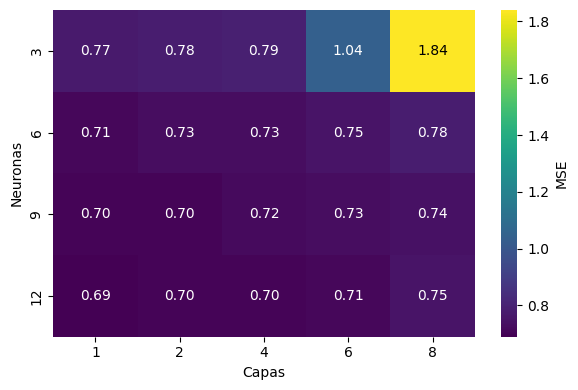

In [235]:
from matplotlib.colors import Normalize

# Crear la figura
plt.figure(figsize=(6, 4))

# Configurar el colormap y la normalización
cmap = plt.get_cmap("viridis")
norm = Normalize(vmin=pivot_table.min().min(), vmax=pivot_table.max().max())

# Dibujar el mapa de calor
ax = sns.heatmap(pivot_table, cmap=cmap, cbar_kws={'label': 'MSE'}, annot=False)

# Anotar manualmente con contraste adecuado
for y in range(pivot_table.shape[0]):
    for x in range(pivot_table.shape[1]):
        value = pivot_table.iloc[y, x]
        rgba = cmap(norm(value))
        brightness = rgba[0]*0.299 + rgba[1]*0.587 + rgba[2]*0.114  # Luma perceptual
        text_color = 'black' if brightness > 0.5 else 'white'
        ax.text(x + 0.5, y + 0.5, f"{value:.2f}",
                ha='center', va='center', color=text_color, fontsize=10)

# Etiquetas y formato
#plt.title("Mapa de Calor - MSE Validación - Neuronas vs Capas ocultas")
plt.xlabel("Capas")
plt.ylabel("Neuronas")
plt.tight_layout()
plt.show()